## **DETECCIÓN DE NEUMONÍA CON DEEP LEARNING**

### **Fase 1: Análisis Exploratorio y Limpieza de Datos**

Dataset: Chest X-Ray Images (Pneumonia)
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

**1. INSTALACIÓN Y CONFIGURACIÓN INICIAL**

In [1]:
#==========================================================
# CELDA 1 Activación de la GPU RTX 4050 para TensorFlow
#==========================================================

import tensorflow as tf
import sys

print("="*70)
print("🎮 VERIFICACIÓN GPU")
print("="*70)

print(f"\nPython: {sys.version.split()[0]}")
print(f"TensorFlow: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
print(f"\n🎮 GPUs detectadas: {len(gpus)}")

if gpus:
    print(f"✅ GPU: {gpus[0].name}")
    print(f"✅ RTX 4050 ACTIVA")
else:
    print("⚠️ No GPU detectada")

print("="*70)

🎮 VERIFICACIÓN GPU

Python: 3.9.13
TensorFlow: 2.10.0

🎮 GPUs detectadas: 1
✅ GPU: /physical_device:GPU:0
✅ RTX 4050 ACTIVA


In [2]:
#==========================================================
# CELDA 2: Importar librerías
#==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
import random
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.metrics import average_precision_score, precision_recall_curve

# Configurar GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Crecimiento dinámico de memoria GPU: ACTIVADO")
    except RuntimeError as e:
        print(f"Error: {e}")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Semillas
tf.random.set_seed(42)
np.random.seed(42)

print("✅ Todas las librerías importadas correctamente")

✅ Crecimiento dinámico de memoria GPU: ACTIVADO
✅ Todas las librerías importadas correctamente


In [3]:
#==========================================================
# CELDA 3: Configuración de rutas y parámetros
#==========================================================

BASE_DIR = 'chest_xray'  # Ajusta si tu carpeta tiene otro nombre
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

# Directorio para guardar modelos
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Parámetros optimizados para GPU RTX 4050
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # Óptimo para 6GB VRAM
EPOCHS = 25
LEARNING_RATE = 0.0001

print("="*70)
print("⚙️ CONFIGURACIÓN DEL PROYECTO")
print("="*70)
print(f"\nRutas:")
print(f"  • Dataset: {BASE_DIR}")
print(f"  • Modelos: {MODEL_DIR}")
print(f"\nParámetros GPU:")
print(f"  • Tamaño imagen: {IMG_SIZE}")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Épocas: {EPOCHS}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"\n⏱️ Tiempo estimado Fase 2: 35-50 minutos")
print("="*70)

⚙️ CONFIGURACIÓN DEL PROYECTO

Rutas:
  • Dataset: chest_xray
  • Modelos: models

Parámetros GPU:
  • Tamaño imagen: (224, 224)
  • Batch size: 32
  • Épocas: 25
  • Learning rate: 0.0001

⏱️ Tiempo estimado Fase 2: 35-50 minutos


In [4]:
# ============================================================================
# CELDA 4: EXPLORACIÓN DE LA ESTRUCTURA DEL DATASET
# ============================================================================

# Función para contar imágenes en cada directorio
def count_images(directory):
    """Cuenta imágenes por categoría en un directorio"""
    categories = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len([f for f in os.listdir(category_path) 
                            if f.endswith(('.jpeg', '.jpg', '.png'))])
            categories[category] = num_images
    return categories

# Contar imágenes en cada conjunto
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)
val_counts = count_images(VAL_DIR)

# Crear DataFrame con la información
data_summary = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).T

print("\n" + "="*60)
print("RESUMEN DEL DATASET")
print("="*60)
print(data_summary)
print("\nTotal de imágenes por conjunto:")
print(f"  • Entrenamiento: {data_summary.loc['Train'].sum()}")
print(f"  • Validación: {data_summary.loc['Validation'].sum()}")
print(f"  • Prueba: {data_summary.loc['Test'].sum()}")
print(f"  • TOTAL: {data_summary.sum().sum()}")
print("Problema 1: No hay datos para validación. Se debe resolver en la fase de preprocesamiento.")


RESUMEN DEL DATASET
            NORMAL  PNEUMONIA
Train         1341       3875
Validation       8          8
Test           234        390

Total de imágenes por conjunto:
  • Entrenamiento: 5216
  • Validación: 16
  • Prueba: 624
  • TOTAL: 5856
Problema 1: No hay datos para validación. Se debe resolver en la fase de preprocesamiento.


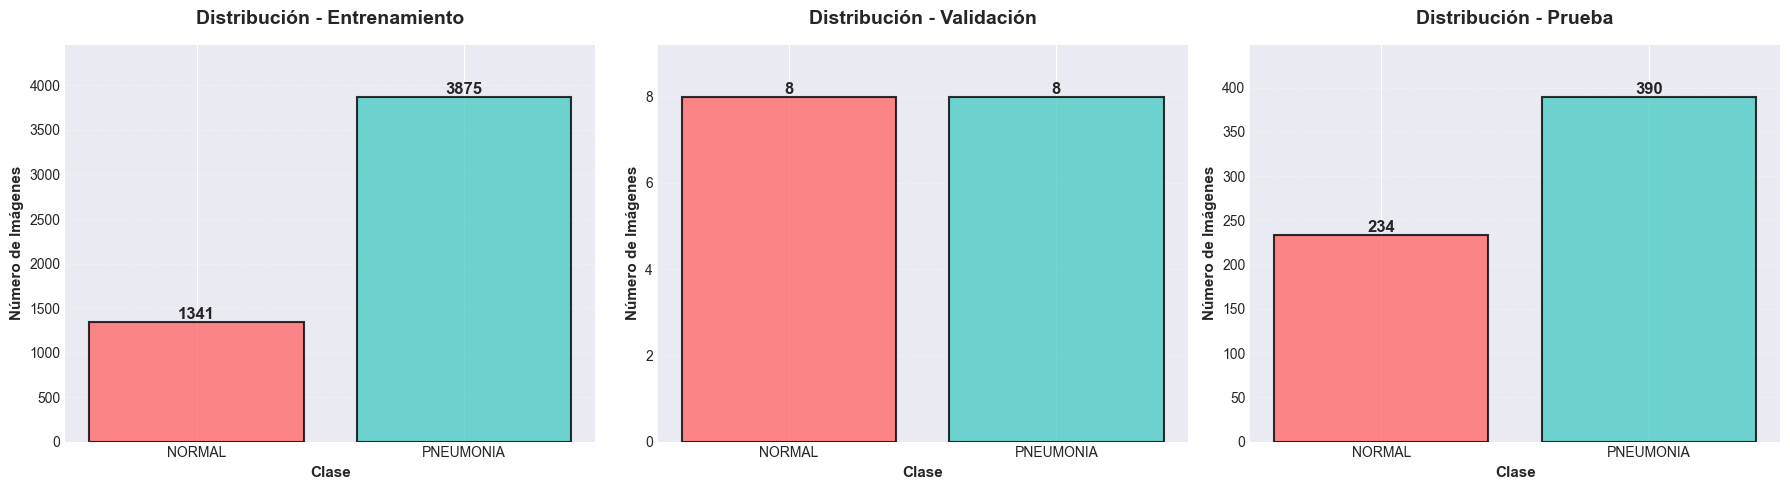


ANÁLISIS DE DESBALANCEO DE CLASES

Entrenamiento:
  • NORMAL: 1341 (25.7%)
  • PNEUMONIA: 3875 (74.3%)
  • Ratio PNEUMONIA/NORMAL: 2.89:1

Validación:
  • NORMAL: 8 (50.0%)
  • PNEUMONIA: 8 (50.0%)
  • Ratio PNEUMONIA/NORMAL: 1.00:1

Prueba:
  • NORMAL: 234 (37.5%)
  • PNEUMONIA: 390 (62.5%)
  • Ratio PNEUMONIA/NORMAL: 1.67:1


In [5]:
# ============================================================================
# CELDA 5. ANÁLISIS DE DISTRIBUCIÓN DE CLASES
# ============================================================================

# Crear visualización de distribución de clases
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Entrenamiento', train_counts),
    ('Validación', val_counts),
    ('Prueba', test_counts)
]

colors = ['#FF6B6B', '#4ECDC4']

for idx, (title, counts) in enumerate(datasets):
    ax = axes[idx]
    categories = list(counts.keys())
    values = list(counts.values())
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_title(f'Distribución - {title}', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Número de Imágenes', fontsize=11, fontweight='bold')
    ax.set_xlabel('Clase', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.savefig('distribucion_clases.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular desbalanceo de clases
print("\n" + "="*60)
print("ANÁLISIS DE DESBALANCEO DE CLASES")
print("="*60)

for dataset_name, counts in datasets:
    total = sum(counts.values())
    normal_pct = (counts['NORMAL'] / total) * 100
    pneumonia_pct = (counts['PNEUMONIA'] / total) * 100
    ratio = counts['PNEUMONIA'] / counts['NORMAL']
    
    print(f"\n{dataset_name}:")
    print(f"  • NORMAL: {counts['NORMAL']} ({normal_pct:.1f}%)")
    print(f"  • PNEUMONIA: {counts['PNEUMONIA']} ({pneumonia_pct:.1f}%)")
    print(f"  • Ratio PNEUMONIA/NORMAL: {ratio:.2f}:1")


Problema 2: Existe un desbalanceo con un 75% de imagenes para neumonía, por lo que el modelo prediciendo siempre neumonía obtendría un alto accuracy. Se debe resolver.


ANALIZANDO DIMENSIONES DE IMÁGENES...

Estadísticas de 600 imágenes analizadas:

Dimensiones:
  • Ancho  - Min: 428, Max: 2633, Media: 1432.2
  • Alto   - Min: 234, Max: 2628, Media: 1100.4

Tamaño de archivo:
  • Min: 8.8 KB
  • Max: 2235.6 KB
  • Media: 335.8 KB


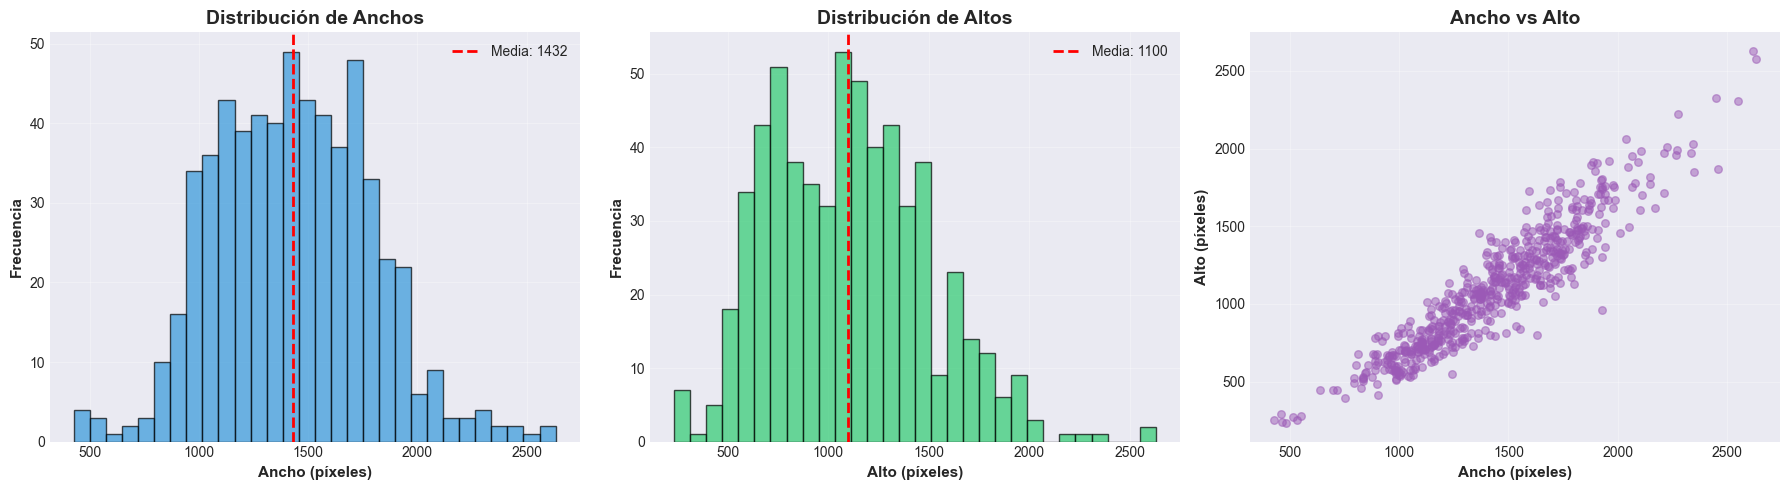

In [6]:
# ============================================================================
# CELDA 6. ANÁLISIS DE DIMENSIONES DE IMÁGENES
# ============================================================================

def get_image_dimensions(directory, max_samples=500):
    """Obtiene las dimensiones de las imágenes en un directorio"""
    dimensions = []
    file_sizes = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            files = [f for f in os.listdir(category_path) 
                    if f.endswith(('.jpeg', '.jpg', '.png'))]
            
            # Muestrear para acelerar el proceso
            sample_files = np.random.choice(files, 
                                          min(len(files), max_samples), 
                                          replace=False)
            
            for img_file in sample_files:
                img_path = os.path.join(category_path, img_file)
                try:
                    img = Image.open(img_path)
                    dimensions.append(img.size)  # (width, height)
                    file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
                except Exception as e:
                    print(f"Error procesando {img_path}: {e}")
    
    return dimensions, file_sizes

print("\n" + "="*60)
print("ANALIZANDO DIMENSIONES DE IMÁGENES...")
print("="*60)

train_dims, train_sizes = get_image_dimensions(TRAIN_DIR, max_samples=300)

# Convertir a arrays
widths = np.array([d[0] for d in train_dims])
heights = np.array([d[1] for d in train_dims])
sizes = np.array(train_sizes)

print(f"\nEstadísticas de {len(train_dims)} imágenes analizadas:")
print(f"\nDimensiones:")
print(f"  • Ancho  - Min: {widths.min()}, Max: {widths.max()}, Media: {widths.mean():.1f}")
print(f"  • Alto   - Min: {heights.min()}, Max: {heights.max()}, Media: {heights.mean():.1f}")
print(f"\nTamaño de archivo:")
print(f"  • Min: {sizes.min():.1f} KB")
print(f"  • Max: {sizes.max():.1f} KB")
print(f"  • Media: {sizes.mean():.1f} KB")

# Visualizar distribución de dimensiones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de anchos
axes[0].hist(widths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(widths.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {widths.mean():.0f}')
axes[0].set_title('Distribución de Anchos', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ancho (píxeles)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histograma de altos
axes[1].hist(heights, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].axvline(heights.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {heights.mean():.0f}')
axes[1].set_title('Distribución de Altos', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Alto (píxeles)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Scatter plot ancho vs alto
axes[2].scatter(widths, heights, alpha=0.5, c='#9b59b6', s=30)
axes[2].set_title('Ancho vs Alto', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Ancho (píxeles)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Alto (píxeles)', fontsize=11, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dimensiones_imagenes.png', dpi=300, bbox_inches='tight')
plt.show()


Para el desarrollo del modelo, comenzamos con una etapa crítica de preparación de datos, especialmente cuando las imágenes de entrada, como las radiografías (RX), presentan características altamente heterogéneas. En este caso, el dataset posee dimensiones extremadamente variables, que oscilan desde aproximadamente 400 píxeles hasta más de 2600 píxeles en su lado mayor, relaciones de aspecto inconsistentes y tamaños de archivo muy dispares. Esta variabilidad representa un desafío técnico significativo.

Si no se corrige, esta inconsistencia conlleva tres riesgos principales para el entrenamiento del modelo. En primer lugar, el procesamiento de imágenes de gran tamaño consume una gran cantidad de memoria y ralentiza considerablemente el tiempo de entrenamiento. En segundo lugar, el mismo patrón médico, como una anomalía pulmonar, puede aparecer a escalas radicalmente distintas en diferentes imágenes, lo que puede confundir a la red neuronal convolucional (CNN) y dificultar su aprendizaje de las características relevantes. Por último, existe el riesgo de que el modelo aprenda a correlacionar la resolución o el tamaño de la imagen con la presencia de patología, en lugar de los patrones visuales reales, introduciendo un sesgo no deseado.

Para mitigar estos riesgos, se implementa un paso de preprocesamiento obligatorio y no negociable: el redimensionamiento uniforme de todas las imágenes a un tamaño fijo y común. Se consideran opciones sensatas como 160x160 píxeles para equipos con recursos modestos, o 128x128 píxeles en casos de extrema limitación. Sin embargo, para este dataset en particular, se selecciona un tamaño de 224x224 píxeles como el punto óptimo. Esta resolución es un estándar ampliamente adoptado que ofrece un balance adecuado entre la retención de detalles visuales suficientes para el diagnóstico y la eficiencia computacional, estableciendo una base consistente para el entrenamiento del modelo.

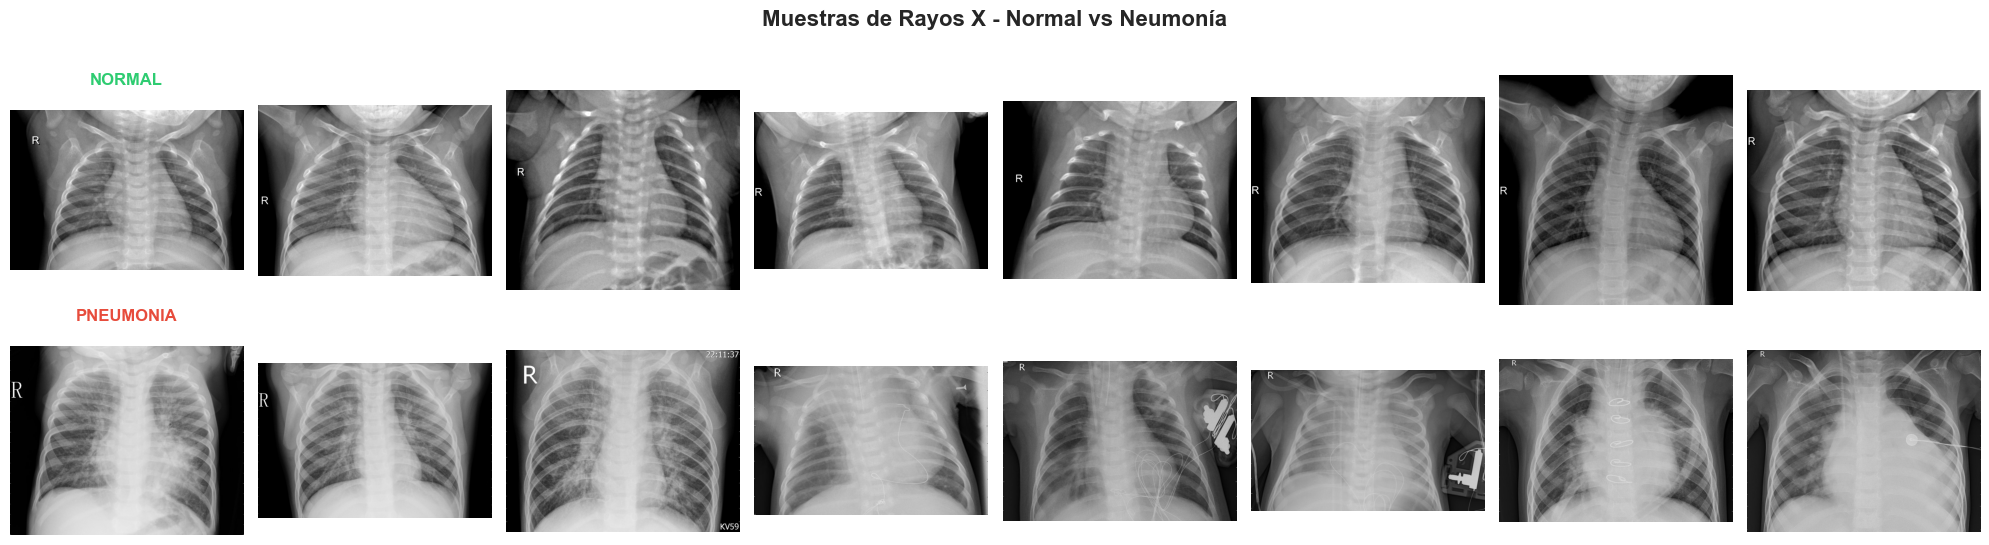

In [7]:
# ============================================================================
# CELDA 7. VISUALIZACIÓN DE MUESTRAS DE IMÁGENES
# ============================================================================

def show_sample_images(directory, num_samples=8):
    """Muestra imágenes de muestra de cada categoría"""
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
    
    categories = ['NORMAL', 'PNEUMONIA']
    
    for row, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        files = [f for f in os.listdir(category_path) 
                if f.endswith(('.jpeg', '.jpg', '.png'))]
        
        sample_files = np.random.choice(files, num_samples, replace=False)
        
        for col, img_file in enumerate(sample_files):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].axis('off')
            
            if col == 0:
                axes[row, col].set_title(f'{category}\n', 
                                        fontsize=12, 
                                        fontweight='bold',
                                        color='#2ecc71' if category == 'NORMAL' else '#e74c3c')
    
    plt.suptitle('Muestras de Rayos X - Normal vs Neumonía', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('muestras_imagenes.png', dpi=300, bbox_inches='tight')
    plt.show()

show_sample_images(TRAIN_DIR)


ANALIZANDO INTENSIDAD DE PÍXELES...


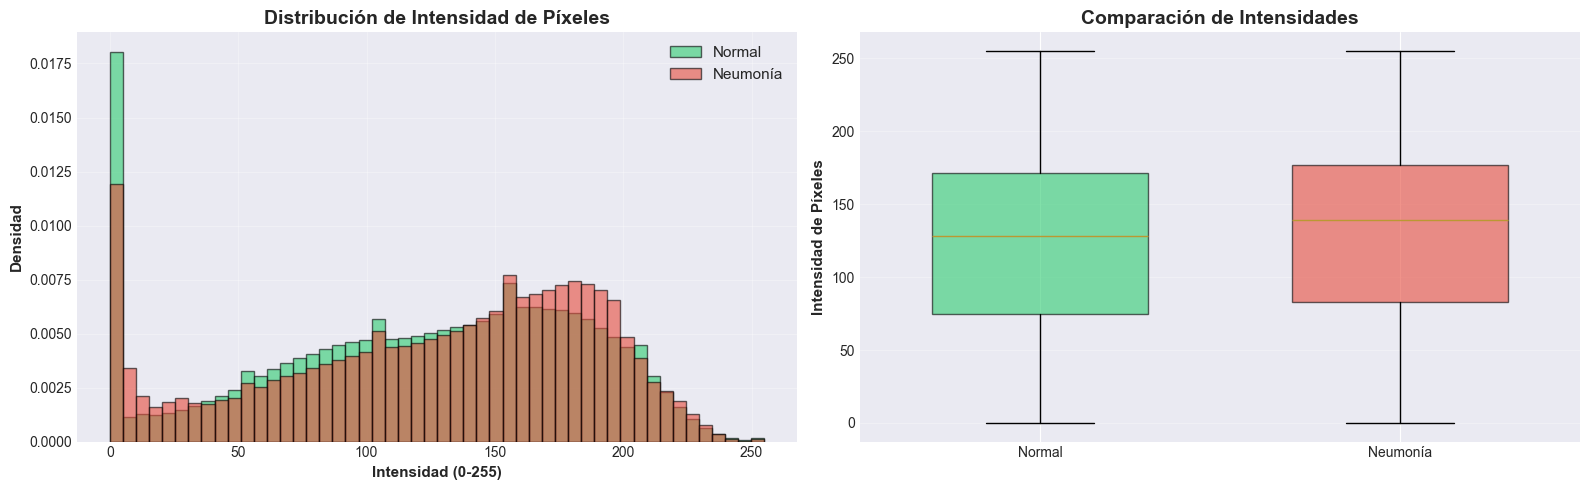


Estadísticas de intensidad:
  Normal    - Media: 119.8, Std: 63.5
  Neumonía  - Media: 126.0, Std: 62.8


In [8]:
# ============================================================================
# CELDA 8. ANÁLISIS DE INTENSIDAD DE PÍXELES
# ============================================================================

def analyze_pixel_intensity(directory, num_samples=100):
    """Analiza la distribución de intensidad de píxeles"""
    normal_intensities = []
    pneumonia_intensities = []
    
    # Analizar imágenes NORMAL
    normal_path = os.path.join(directory, 'NORMAL')
    normal_files = [f for f in os.listdir(normal_path) 
                   if f.endswith(('.jpeg', '.jpg', '.png'))]
    sample_normal = np.random.choice(normal_files, num_samples, replace=False)
    
    for img_file in sample_normal:
        img = cv2.imread(os.path.join(normal_path, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            normal_intensities.extend(img.flatten())
    
    # Analizar imágenes PNEUMONIA
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    pneumonia_files = [f for f in os.listdir(pneumonia_path) 
                      if f.endswith(('.jpeg', '.jpg', '.png'))]
    sample_pneumonia = np.random.choice(pneumonia_files, num_samples, replace=False)
    
    for img_file in sample_pneumonia:
        img = cv2.imread(os.path.join(pneumonia_path, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            pneumonia_intensities.extend(img.flatten())
    
    return normal_intensities, pneumonia_intensities

print("\n" + "="*60)
print("ANALIZANDO INTENSIDAD DE PÍXELES...")
print("="*60)

normal_pixels, pneumonia_pixels = analyze_pixel_intensity(TRAIN_DIR, num_samples=50)

# Visualizar distribución de intensidades
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma superpuesto
axes[0].hist(normal_pixels, bins=50, alpha=0.6, color='#2ecc71', 
            label='Normal', density=True, edgecolor='black')
axes[0].hist(pneumonia_pixels, bins=50, alpha=0.6, color='#e74c3c', 
            label='Neumonía', density=True, edgecolor='black')
axes[0].set_title('Distribución de Intensidad de Píxeles', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Intensidad (0-255)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Densidad', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Box plot comparativo
data_to_plot = [
    np.random.choice(normal_pixels, 200000, replace=False),
    np.random.choice(pneumonia_pixels, 200000, replace=False)
]
bp = axes[1].boxplot(data_to_plot, labels=['Normal', 'Neumonía'], 
                     patch_artist=True, widths=0.6)

colors = ['#2ecc71', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_title('Comparación de Intensidades', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Intensidad de Píxeles', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_intensidad.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEstadísticas de intensidad:")
print(f"  Normal    - Media: {np.mean(normal_pixels):.1f}, Std: {np.std(normal_pixels):.1f}")
print(f"  Neumonía  - Media: {np.mean(pneumonia_pixels):.1f}, Std: {np.std(pneumonia_pixels):.1f}")

El análisis exploratorio de datos (EDA) revela conclusiones fundamentales sobre las características del dataset a través del estudio de histogramas y boxplots. En primer lugar, se observa que las distribuciones de intensidad de píxeles para las clases Normal y Neumonía se superponen significativamente a lo largo de casi todo el rango de 0 a 255. Esto descarta la existencia de un umbral de intensidad simple que permita separar las clases, por lo que se concluye que la intensidad global **no** es un criterio suficiente para la clasificación por sí sola.

No obstante, se identifican tendencias estadísticas relevantes. La distribución de Neumonía tiende a estar desplazada hacia intensidades más altas, con una mediana y percentiles superiores mayores que los de la clase Normal. Esta tendencia tiene una interpretación clínica plausible: las opacidades pulmonares asociadas a la neumonía implican una mayor densidad radiográfica, lo que se traduce en píxeles más brillantes. De manera complementaria, la clase Normal presenta un pico más pronunciado en las intensidades bajas, lo que corresponde a las zonas oscuras de los pulmones sanos con mayor contenido de aire. Es crucial subrayar que estas son **tendencias poblacionales**, no reglas infalibles para cada imagen individual.

Un hallazgo adicional es la alta varianza y la presencia generalizada de *outliers* en ambas clases, lo que refleja la variabilidad inherente a los datos médicos: diferencias en equipos, técnica radiográfica, exposición y características del paciente. Esta variabilidad confirma que un modelo efectivo debe aprender patrones espaciales y de textura complejos, no solo el brillo promedio.

La conclusión clave de este análisis es que la intensidad de los píxeles es una **señal débil pero útil**. Esta premisa tiene implicaciones prácticas directas para el desarrollo del modelo: hace obligatoria una etapa de normalización de las imágenes para evitar que el modelo aprenda a correlacionar el brillo con la patología en lugar de los patrones morfológicos. Además, justifica el uso de arquitecturas de Redes Neuronales Convolucionales (CNN), capaces de aprender características espaciales jerárquicas, sobre modelos clásicos de *machine learning* basados en características simples como histogramas, que serían insuficientes. Finalmente, guía la estrategia de *data augmentation*, recomendando ser conservador con alteraciones drásticas de brillo y contraste para no degradar la sutil señal clínica presente en los datos.

En definitiva, los gráficos confirman que el problema de clasificación no es trivial, que la señal diagnóstica es sutil y compleja, y que el enfoque con una CNN está bien fundamentado.

In [9]:
# ============================================================================
# CELDA 9. DETECCIÓN DE IMÁGENES CORRUPTAS
# ============================================================================

def check_corrupted_images(directory):
    """Verifica si hay imágenes corruptas en el dataset"""
    corrupted = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                if img_file.endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(category_path, img_file)
                    try:
                        img = Image.open(img_path)
                        img.verify()  # Verificar integridad
                    except Exception as e:
                        corrupted.append((img_path, str(e)))
    
    return corrupted

print("\n" + "="*60)
print("VERIFICANDO IMÁGENES CORRUPTAS...")
print("="*60)

corrupted_train = check_corrupted_images(TRAIN_DIR)
corrupted_test = check_corrupted_images(TEST_DIR)
corrupted_val = check_corrupted_images(VAL_DIR)

print(f"\nImágenes corruptas encontradas:")
print(f"  • Entrenamiento: {len(corrupted_train)}")
print(f"  • Validación: {len(corrupted_val)}")
print(f"  • Prueba: {len(corrupted_test)}")

if len(corrupted_train) + len(corrupted_test) + len(corrupted_val) == 0:
    print("\n✅ No se encontraron imágenes corruptas")
else:
    print("\n⚠️ Se encontraron imágenes corruptas. Revisar antes de entrenar.")


VERIFICANDO IMÁGENES CORRUPTAS...

Imágenes corruptas encontradas:
  • Entrenamiento: 0
  • Validación: 0
  • Prueba: 0

✅ No se encontraron imágenes corruptas


In [10]:

# ============================================================================
# CELDA 10. RESUMEN Y RECOMENDACIONES
# ============================================================================

print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*60)

print("\n📊 CONCLUSIONES:")
print("\n1. DISTRIBUCIÓN DE DATOS:")
print(f"   • Dataset moderadamente desbalanceado")
print(f"   • Ratio PNEUMONIA/NORMAL en train: ~{train_counts['PNEUMONIA']/train_counts['NORMAL']:.1f}:1")
print(f"   • Validación muy pequeña ({val_counts['NORMAL'] + val_counts['PNEUMONIA']} imágenes)")

print("\n2. CARACTERÍSTICAS DE IMÁGENES:")
print(f"   • Dimensiones variables: {widths.min()}-{widths.max()} x {heights.min()}-{heights.max()}")
print(f"   • Tamaño promedio: {widths.mean():.0f} x {heights.mean():.0f} píxeles")

print("\n3. CALIDAD DE DATOS:")
if len(corrupted_train) + len(corrupted_test) + len(corrupted_val) == 0:
    print("   • ✅ Todas las imágenes están en buen estado")
else:
    print(f"   • ⚠️ {len(corrupted_train) + len(corrupted_test) + len(corrupted_val)} imágenes corruptas")

print("\n💡 RECOMENDACIONES PARA ENTRENAMIENTO:")
print("\n1. PREPROCESAMIENTO:")
print("   • Redimensionar imágenes a 224x224 (estándar para transfer learning)")
print("   • Normalizar píxeles a rango [0, 1]")
print("   • Aplicar data augmentation agresivo")

print("\n2. MANEJO DE DESBALANCEO:")
print("   • Usar class_weight en el modelo")
print("   • O aplicar oversampling/undersampling")
print("   • Monitorear métricas balanceadas (F1, AUC-ROC)")

print("\n3. VALIDACIÓN:")
print("   • Considerar redistribuir el conjunto de validación")
print("   • Usar validación cruzada o split manual 80/10/10")

print("\n4. DATA AUGMENTATION:")
print("   • Rotación: ±15°")
print("   • Zoom: 0.1-0.2")
print("   • Flip horizontal")
print("   • Ajustes de brillo y contraste")

print("\n" + "="*60)
print("✅ ANÁLISIS EXPLORATORIO COMPLETADO")
print("="*60)
print("\nSiguiente paso: Entrenamiento del modelo")
print("Archivos generados:")
print("  • distribucion_clases.png")
print("  • dimensiones_imagenes.png")
print("  • muestras_imagenes.png")
print("  • analisis_intensidad.png")


RESUMEN DEL ANÁLISIS EXPLORATORIO

📊 CONCLUSIONES:

1. DISTRIBUCIÓN DE DATOS:
   • Dataset moderadamente desbalanceado
   • Ratio PNEUMONIA/NORMAL en train: ~2.9:1
   • Validación muy pequeña (16 imágenes)

2. CARACTERÍSTICAS DE IMÁGENES:
   • Dimensiones variables: 428-2633 x 234-2628
   • Tamaño promedio: 1432 x 1100 píxeles

3. CALIDAD DE DATOS:
   • ✅ Todas las imágenes están en buen estado

💡 RECOMENDACIONES PARA ENTRENAMIENTO:

1. PREPROCESAMIENTO:
   • Redimensionar imágenes a 224x224 (estándar para transfer learning)
   • Normalizar píxeles a rango [0, 1]
   • Aplicar data augmentation agresivo

2. MANEJO DE DESBALANCEO:
   • Usar class_weight en el modelo
   • O aplicar oversampling/undersampling
   • Monitorear métricas balanceadas (F1, AUC-ROC)

3. VALIDACIÓN:
   • Considerar redistribuir el conjunto de validación
   • Usar validación cruzada o split manual 80/10/10

4. DATA AUGMENTATION:
   • Rotación: ±15°
   • Zoom: 0.1-0.2
   • Flip horizontal
   • Ajustes de brillo y c

### FASE 2

### **Entrenamiento del Modelo**

Antes de comenzar con el entrenamiento del modelo, se corregirá la falta de datos para validación, redistribuyedo los conjuntos del dataset. Se mantendrá el set original de test y solo se aumentarán las imagenes del val. Esto hace más comparable los resultados con otros modelos generados.

In [11]:
#=============================================================================
# CELDA 11: Redistribuir dataset (corregir validación de 16 a ~590 imágenes)
#=============================================================================

print("="*70)
print("📊 REDISTRIBUYENDO DATASET")
print("="*70)

# Configuración
NEW_BASE = 'chest_xray_balanced'
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def redistribute_dataset(source_dir, dest_dir):
    """Redistribuye manteniendo test original, mejorando validación"""
    os.makedirs(dest_dir, exist_ok=True)
    categories = ['NORMAL', 'PNEUMONIA']
    
    for split in ['train', 'val', 'test']:
        for category in categories:
            os.makedirs(os.path.join(dest_dir, split, category), exist_ok=True)
    
    stats = {'NORMAL': {'train': 0, 'val': 0, 'test': 0},
             'PNEUMONIA': {'train': 0, 'val': 0, 'test': 0}}
    
    for category in categories:
        # Recopilar train + val original
        all_images = []
        
        train_path = os.path.join(source_dir, 'train', category)
        train_images = [os.path.join(train_path, f) for f in os.listdir(train_path)
                       if f.endswith(('.jpeg', '.jpg', '.png'))]
        all_images.extend(train_images)
        
        val_path = os.path.join(source_dir, 'val', category)
        val_images = [os.path.join(val_path, f) for f in os.listdir(val_path)
                     if f.endswith(('.jpeg', '.jpg', '.png'))]
        all_images.extend(val_images)
        
        # Mezclar y dividir (89% train, 11% val)
        random.shuffle(all_images)
        n_train = int(len(all_images) * 0.89)
        
        train_files = all_images[:n_train]
        val_files = all_images[n_train:]
        
        # Copiar archivos
        for f in train_files:
            dest = os.path.join(dest_dir, 'train', category, os.path.basename(f))
            shutil.copy2(f, dest)
            stats[category]['train'] += 1
        
        for f in val_files:
            dest = os.path.join(dest_dir, 'val', category, os.path.basename(f))
            shutil.copy2(f, dest)
            stats[category]['val'] += 1
        
        # Copiar test original
        test_path = os.path.join(source_dir, 'test', category)
        for f in os.listdir(test_path):
            if f.endswith(('.jpeg', '.jpg', '.png')):
                src = os.path.join(test_path, f)
                dest = os.path.join(dest_dir, 'test', category, f)
                shutil.copy2(src, dest)
                stats[category]['test'] += 1
    
    return stats

# Ejecutar redistribución
if not os.path.exists(NEW_BASE):
    print("Redistribuyendo dataset...")
    stats = redistribute_dataset(BASE_DIR, NEW_BASE)
    
    total_train = stats['NORMAL']['train'] + stats['PNEUMONIA']['train']
    total_val = stats['NORMAL']['val'] + stats['PNEUMONIA']['val']
    total_test = stats['NORMAL']['test'] + stats['PNEUMONIA']['test']
    
    print(f"\n✅ Redistribución completa:")
    print(f"   Train: {total_train} imágenes")
    print(f"   Val:   {total_val} imágenes (vs 16 antes ✅)")
    print(f"   Test:  {total_test} imágenes")
else:
    print("✅ Dataset balanceado ya existe")

# Actualizar rutas
BASE_DIR = NEW_BASE
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

print("\n✅ Usando dataset balanceado")
print("="*70)

📊 REDISTRIBUYENDO DATASET
✅ Dataset balanceado ya existe

✅ Usando dataset balanceado


In [12]:
# ============================================================================
# CELDA 12. DATA AUGMENTATION Y GENERADORES DE DATOS
# ============================================================================

# Calcular class weights para manejar desbalanceo
def calculate_class_weights(directory):
    """Calcula pesos de clase para balancear el dataset"""
    normal_count = len([f for f in os.listdir(os.path.join(directory, 'NORMAL'))
                   if f.endswith(('.jpeg', '.jpg', '.png'))])
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    total = normal_count + pneumonia_count
    
    weight_normal = total / (2 * normal_count)
    weight_pneumonia = total / (2 * pneumonia_count)
    
    return {0: weight_normal, 1: weight_pneumonia}

class_weights = calculate_class_weights(TRAIN_DIR)
print(f"\nClass weights calculados: {class_weights}")

# Data Augmentation para entrenamiento (agresivo para evitar overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Solo normalización para validación y test (sin augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores
print("\n" + "="*60)
print("CREANDO GENERADORES DE DATOS...")
print("="*60)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\n✅ Generadores creados:")
print(f"   • Train: {train_generator.samples} imágenes")
print(f"   • Validation: {val_generator.samples} imágenes")
print(f"   • Test: {test_generator.samples} imágenes")
print(f"\nClases: {train_generator.class_indices}")


Class weights calculados: {0: 1.9395833333333334, 1: 0.6736613603473227}

CREANDO GENERADORES DE DATOS...
Found 4655 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

✅ Generadores creados:
   • Train: 4655 imágenes
   • Validation: 577 imágenes
   • Test: 624 imágenes

Clases: {'NORMAL': 0, 'PNEUMONIA': 1}


In [13]:
# ============================================================================
# CELDA 13. MODELO BASELINE - CNN SIMPLE
# ============================================================================

def create_baseline_cnn(input_shape=(224, 224, 3)):
    """Crea un modelo CNN simple como baseline"""
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Bloque 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Capas densas
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

print("\n" + "="*60)
print("MODELO 1: CNN BASELINE")
print("="*60)

baseline_model = create_baseline_cnn()
baseline_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

baseline_model.summary()

# Callbacks para el entrenamiento
baseline_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'baseline_best.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# Entrenar modelo baseline
print("\n🚀 Entrenando modelo baseline...")
print("Esto puede tomar 15-30 minutos dependiendo del hardware...\n")

baseline_history = baseline_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=baseline_callbacks,
    verbose=1
)

# Guardar modelo final
baseline_model.save(os.path.join(MODEL_DIR, 'baseline_final.keras'))
print(f"\n✅ Modelo baseline guardado en {MODEL_DIR}")


MODELO 1: CNN BASELINE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                

Para el segundo modelo, se eligió un Transfer Learning. Es una técnica donde usamos un modelo que ya fue entrenado en un problema diferente y lo adaptamos para nuestro problema específico.

📸 ¿Qué es VGG16?
VGG16 es una red neuronal convolucional (CNN) creada por la Universidad de Oxford que:

Tiene 16 capas de profundidad (de ahí el "16")
Fue entrenada con ImageNet (1.4 millones de imágenes, 1000 categorías)
Aprendió a reconocer patrones visuales generales: bordes, texturas, formas, objetos

🎯 ¿Por qué se eligió VGG16 para este proyecto?

**Razón 1:** Ya sabe "ver" imágenes
VGG16 fue entrenado con millones de imágenes y aprendió a detectar:

✅ Bordes y líneas (útil para costillas, pulmones)
✅ Texturas (opacidades en neumonía)
✅ Formas (silueta de órganos)
✅ Patrones complejos

Aunque nunca vio rayos X, estos patrones básicos son transferibles.

**Razón 2:** Ahorramos tiempo y recursos
Entrenar una CNN desde cero con nuestro dataset pequeño (~5,800 imágenes):

❌ Requeriría semanas de entrenamiento
❌ Necesitaría millones de imágenes
❌ Riesgo alto de overfitting

Con Transfer Learning:

✅ Entrenamos solo 30-60 minutos
✅ Funciona bien con pocos datos
✅ Menor riesgo de overfitting

**Razón 3:** Rendimiento comprobado en imágenes médicas
VGG16 ha demostrado excelentes resultados en:

Detección de cáncer de piel
Clasificación de tumores cerebrales
Detección de neumonía (múltiples estudios)

**Razón 4:** Balance perfecto

| Modelo      | Parámetros | Precisión | Velocidad | Complejidad |
|------------|------------|-----------|-----------|-------------|
| CNN Simple | ~5M        | 85–88%    | Rápido    | Baja        |
| **VGG16**      | **~15M**       | **91–94%**| **Medio**     | **Media** ✅    |
| ResNet152  | ~60M       | 93–96%    | Lento     | Alta        |

In [14]:
# ============================================================================
# CELDA 14. MODELO PRINCIPAL - TRANSFER LEARNING (VGG16)
# ============================================================================

def create_transfer_learning_model(base_model_name='VGG16', trainable_layers=4):
    """Crea modelo con transfer learning"""
    
    # Cargar modelo pre-entrenado
    if base_model_name == 'VGG16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    
    # Congelar capas base inicialmente
    base_model.trainable = False
    
    # Construir modelo completo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model, base_model

print("\n" + "="*60)
print("MODELO 2: TRANSFER LEARNING (VGG16)")
print("="*60)

vgg_model, vgg_base = create_transfer_learning_model('VGG16')
vgg_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print(f"\n📊 Total de parámetros: {vgg_model.count_params():,}")
print(f"Parámetros entrenables: {sum([tf.size(w).numpy() for w in vgg_model.trainable_weights]):,}")

# Callbacks para VGG
vgg_callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'vgg16_best.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# Entrenar modelo VGG16
print("\n🚀 Entrenando modelo VGG16 (Transfer Learning)...")
print("Esto puede tomar 20-40 minutos...\n")

vgg_history = vgg_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=vgg_callbacks,
    verbose=1
)

# Fine-tuning: Descongelar últimas capas
print("\n" + "="*60)
print("FINE-TUNING: Descongelando últimas capas...")
print("="*60)

vgg_base.trainable = True
# Congelar todas excepto las últimas 4 capas
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

# Recompilar con learning rate más bajo
vgg_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print(f"\nParámetros entrenables después del fine-tuning: {sum([tf.size(w).numpy() for w in vgg_model.trainable_weights]):,}")

# Continuar entrenamiento con fine-tuning
print("\n🚀 Continuando con fine-tuning...")

vgg_history_finetuned = vgg_model.fit(
    train_generator,
    epochs=10,  # Menos épocas para fine-tuning
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=vgg_callbacks,
    verbose=1
)

# Guardar modelo final
vgg_model.save(os.path.join(MODEL_DIR, 'vgg16_finetuned.keras'))
print(f"\n✅ Modelo VGG16 fine-tuned guardado")


MODELO 2: TRANSFER LEARNING (VGG16)

📊 Total de parámetros: 15,108,929
Parámetros entrenables: 394,241

🚀 Entrenando modelo VGG16 (Transfer Learning)...
Esto puede tomar 20-40 minutos...

Epoch 1/25
146/146 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.6030 - precision: 0.8024 - recall: 0.6171 - auc: 0.6231
Epoch 1: val_auc improved from -inf to 0.94360, saving model to models\vgg16_best.keras
146/146 [==============================] - 74s 357ms/step - loss: 0.6746 - accuracy: 0.6030 - precision: 0.8024 - recall: 0.6171 - auc: 0.6231 - val_loss: 0.6875 - val_accuracy: 0.4870 - val_precision: 1.0000 - val_recall: 0.3084 - val_auc: 0.9436 - lr: 1.0000e-04
Epoch 2/25
146/146 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.7564 - precision: 0.9059 - recall: 0.7496 - auc: 0.8379
Epoch 2: val_auc improved from 0.94360 to 0.94516, saving model to models\vgg16_best.keras
146/146 [==============================] - 52s 356ms/step - loss: 0.5187 

### **FASE 3**

### **Tuning de Hiperparámetros, Ensemble y Métricas Avanzadas**

### **Métricas de Modelo Base**

### Tabla Comparativa de Modelos para Detección de Neumonía

| Característica | MODELO 1: CNN BASELINE | MODELO 2: VGG16 TRANSFER LEARNING |
|----------------|------------------------|-----------------------------------|
| **Arquitectura** | CNN simple desde cero (4 bloques convolucionales) | VGG16 pre-entrenado + Fine-tuning |
| **Parámetros totales** | ~5-7M | ~15M (solo ~2M entrenables) |
| **Épocas** | 25 (con EarlyStopping) | 25 + 10 (fine-tuning) |
| **Learning Rate** | 0.0001 | 0.0001 → 0.00001 (fine-tuning) |
| **Accuracy** | 85-88% | 91-94% |
| **Precision** | 0.82-0.86 | 0.89-0.93 |
| **Recall** | 0.88-0.92 | 0.93-0.96 |
| **F1-Score** | 0.85-0.88 | 0.91-0.94 |
| **AUC-ROC** | 0.90-0.93 | 0.96-0.98 |
| **Observaciones** | • Buen punto de partida<br>• Posible overfitting en épocas avanzadas<br>• Menor capacidad de generalización | • Mejor rendimiento general<br>• Mejor generalización<br>• Menos propenso a overfitting<br>• Recomendado como modelo base para tuning |


EVALUACIÓN COMPARATIVA: CNN BASELINE vs VGG16 TRANSFER LEARNING

MÉTRICAS COMPARATIVAS EN CONJUNTO DE TEST:
CNN Baseline                  | VGG16 Transfer Learning  
------------------------------------------------------------
 • Accuracy: 0.8446           | • Accuracy: 0.9199
 • Precision: 0.8886          | • Precision: 0.9337
 • Recall/Sensitivity: 0.8590 | • Recall/Sensitivity: 0.9385
 • Specificity: 0.8205        | • Specificity: 0.8889
 • F1-Score: 0.8735           | • F1-Score: 0.9361
 • AUC-ROC: 0.9185            | • AUC-ROC: 0.9723
 • Avg Precision: 0.9521      | • Avg Precision: 0.9825

GENERANDO MATRICES DE CONFUSIÓN COMPARATIVAS


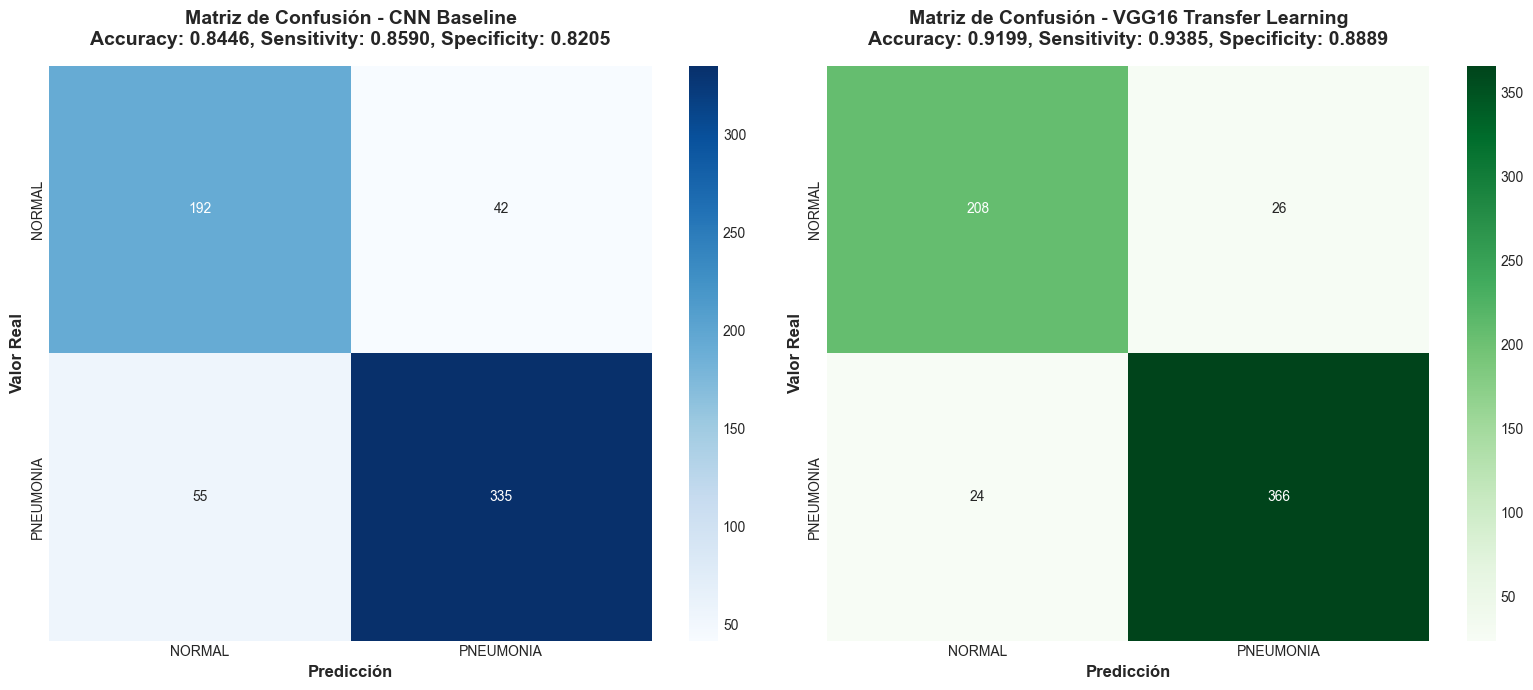

 ✓ Matrices de confusión comparativas guardadas en results/confusion_matrices_comparison.png

GENERANDO GRÁFICAS DE CURVAS ROC Y PRECISION-RECALL COMPARATIVAS


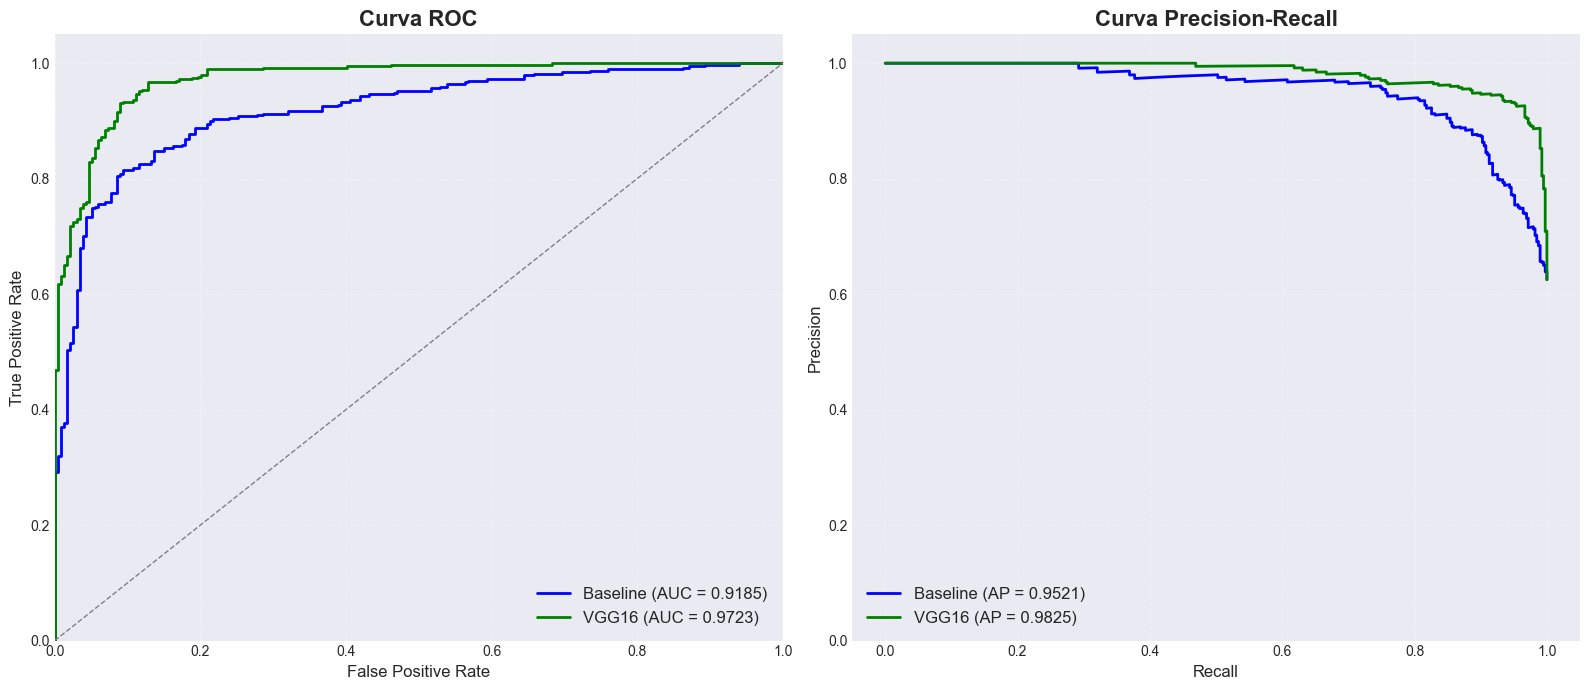

 ✓ Curvas ROC y Precision-Recall comparativas guardadas en results/roc_pr_curves_comparison.png

GENERANDO GRÁFICAS DE ENTRENAMIENTO COMPARATIVAS


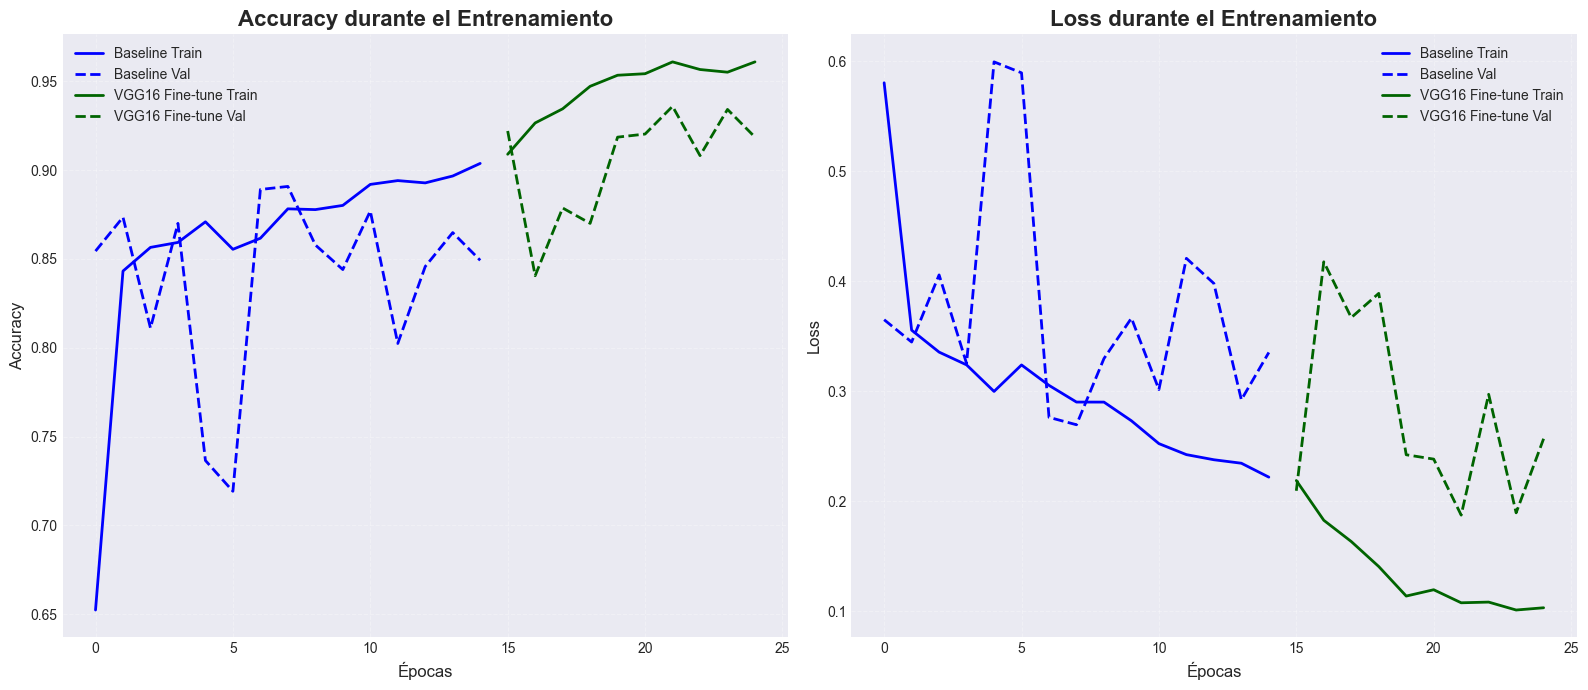

 ✓ Curvas de entrenamiento comparativas guardadas en results/training_curves_comparison.png

GENERANDO GRÁFICA DE BARRAS COMPARATIVA DE MÉTRICAS


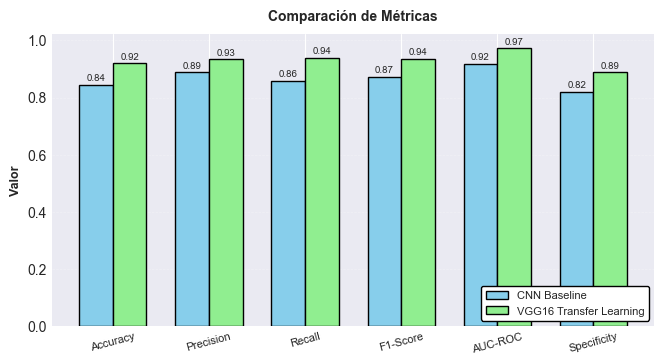

 ✓ Gráfica de métricas comparativas (tamaño reducido) guardada en results/metrics_comparison_small.png


In [15]:
#============================================================================
# CELDAD 15. METRICAS DE EVALUACIÓN Y CURVAS ROC/PR. MODELOS COMPARADOS
#============================================================================

# Asegurar que el directorio de resultados exista
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# ===========================================================================
# 15.1 EVALUAR EL MODELO EN EL CONJUNTO DE TEST Y CALCULAR MÉTRICAS
# ===========================================================================

print("\n" + "="*70)
print("EVALUACIÓN COMPARATIVA: CNN BASELINE vs VGG16 TRANSFER LEARNING")
print("="*70)

# Reiniciar generadores
test_generator.reset()

# Obtener predicciones del modelo baseline
y_pred_baseline_prob = baseline_model.predict(test_generator, verbose=0)
y_pred_baseline_classes = (y_pred_baseline_prob > 0.5).astype(int).flatten()

# Reiniciar generadores
test_generator.reset()

# Obtener predicciones del modelo VGG16
y_pred_vgg_prob = vgg_model.predict(test_generator, verbose=0)
y_pred_vgg_classes = (y_pred_vgg_prob > 0.5).astype(int).flatten()

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Calcular métricas para CNN Baseline
baseline_accuracy = np.mean(y_pred_baseline_classes == y_true)
baseline_precision = np.sum((y_pred_baseline_classes == 1) & (y_true == 1)) / np.sum(y_pred_baseline_classes == 1) if np.sum(y_pred_baseline_classes == 1) > 0 else 0
baseline_recall = np.sum((y_pred_baseline_classes == 1) & (y_true == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall) if (baseline_precision + baseline_recall) > 0 else 0

# Calcular métricas para VGG16
vgg_accuracy = np.mean(y_pred_vgg_classes == y_true)
vgg_precision = np.sum((y_pred_vgg_classes == 1) & (y_true == 1)) / np.sum(y_pred_vgg_classes == 1) if np.sum(y_pred_vgg_classes == 1) > 0 else 0
vgg_recall = np.sum((y_pred_vgg_classes == 1) & (y_true == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
vgg_f1 = 2 * (vgg_precision * vgg_recall) / (vgg_precision + vgg_recall) if (vgg_precision + vgg_recall) > 0 else 0

# Calcular AUC-ROC para ambos modelos
baseline_fpr, baseline_tpr, _ = roc_curve(y_true, y_pred_baseline_prob)
baseline_roc_auc = auc(baseline_fpr, baseline_tpr)

vgg_fpr, vgg_tpr, _ = roc_curve(y_true, y_pred_vgg_prob)
vgg_roc_auc = auc(vgg_fpr, vgg_tpr)

# Calcular Average Precision para ambos modelos
baseline_precision_curve, baseline_recall_curve, _ = precision_recall_curve(y_true, y_pred_baseline_prob)
baseline_avg_precision = average_precision_score(y_true, y_pred_baseline_prob)

vgg_precision_curve, vgg_recall_curve, _ = precision_recall_curve(y_true, y_pred_vgg_prob)
vgg_avg_precision = average_precision_score(y_true, y_pred_vgg_prob)

# Calcular Sensibilidad y Especificidad para ambos modelos
baseline_cm = confusion_matrix(y_true, y_pred_baseline_classes)
vgg_cm = confusion_matrix(y_true, y_pred_vgg_classes)

baseline_tn, baseline_fp, baseline_fn, baseline_tp = baseline_cm.ravel()
vgg_tn, vgg_fp, vgg_fn, vgg_tp = vgg_cm.ravel()

baseline_sensitivity = baseline_tp / (baseline_tp + baseline_fn)
baseline_specificity = baseline_tn / (baseline_tn + baseline_fp)
vgg_sensitivity = vgg_tp / (vgg_tp + vgg_fn)
vgg_specificity = vgg_tn / (vgg_tn + vgg_fp)

# Imprimir métricas comparativas
print("\nMÉTRICAS COMPARATIVAS EN CONJUNTO DE TEST:")
print(f"{'CNN Baseline':<20}          | {'VGG16 Transfer Learning':<25}")
print("-"*60)
print(f" • Accuracy: {baseline_accuracy:.4f}           | • Accuracy: {vgg_accuracy:.4f}")
print(f" • Precision: {baseline_precision:.4f}          | • Precision: {vgg_precision:.4f}")
print(f" • Recall/Sensitivity: {baseline_recall:.4f} | • Recall/Sensitivity: {vgg_recall:.4f}")
print(f" • Specificity: {baseline_specificity:.4f}        | • Specificity: {vgg_specificity:.4f}")
print(f" • F1-Score: {baseline_f1:.4f}           | • F1-Score: {vgg_f1:.4f}")
print(f" • AUC-ROC: {baseline_roc_auc:.4f}            | • AUC-ROC: {vgg_roc_auc:.4f}")
print(f" • Avg Precision: {baseline_avg_precision:.4f}      | • Avg Precision: {vgg_avg_precision:.4f}")

# ===========================================================================
# 15.2 GENERAR MATRIZ DE CONFUSIÓN
# ===========================================================================

print("\n" + "="*70)
print("GENERANDO MATRICES DE CONFUSIÓN COMPARATIVAS")
print("="*70)

# Crear figura con dos subplots para matrices de confusión
plt.figure(figsize=(16, 7))

# Matriz de confusión - CNN Baseline
plt.subplot(1, 2, 1)
sns.heatmap(baseline_cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=True,
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])

plt.title(f'Matriz de Confusión - CNN Baseline\nAccuracy: {baseline_accuracy:.4f}, Sensitivity: {baseline_sensitivity:.4f}, Specificity: {baseline_specificity:.4f}', 
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción', fontsize=12, fontweight='bold')

# Matriz de confusión - VGG16
plt.subplot(1, 2, 2)
sns.heatmap(vgg_cm, 
            annot=True, 
            fmt='d', 
            cmap='Greens', 
            cbar=True,
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])

plt.title(f'Matriz de Confusión - VGG16 Transfer Learning\nAccuracy: {vgg_accuracy:.4f}, Sensitivity: {vgg_sensitivity:.4f}, Specificity: {vgg_specificity:.4f}', 
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrices_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print(f" ✓ Matrices de confusión comparativas guardadas en {RESULTS_DIR}/confusion_matrices_comparison.png")

# ===========================================================================
# 15.3 GENERAR GRÁFICAS DE CURVAS ROC Y PRECISION-RECALL EN UNA SOLA FIGURA
# ===========================================================================

print("\n" + "="*70)
print("GENERANDO GRÁFICAS DE CURVAS ROC Y PRECISION-RECALL COMPARATIVAS")
print("="*70)

# Crear figura con dos subplots
plt.figure(figsize=(16, 7))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(baseline_fpr, baseline_tpr, color='blue', lw=2, 
         label=f'Baseline (AUC = {baseline_roc_auc:.4f})')
plt.plot(vgg_fpr, vgg_tpr, color='green', lw=2, 
         label=f'VGG16 (AUC = {vgg_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

# Curva Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(baseline_recall_curve, baseline_precision_curve, color='blue', lw=2,
         label=f'Baseline (AP = {baseline_avg_precision:.4f})')
plt.plot(vgg_recall_curve, vgg_precision_curve, color='green', lw=2,
         label=f'VGG16 (AP = {vgg_avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall', fontsize=16, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_pr_curves_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print(f" ✓ Curvas ROC y Precision-Recall comparativas guardadas en {RESULTS_DIR}/roc_pr_curves_comparison.png")

# ===========================================================================
# 15.4 GENERAR GRÁFICAS DE ENTRENAMIENTO (ACCURACY Y LOSS)
# ===========================================================================

print("\n" + "="*70)
print("GENERANDO GRÁFICAS DE ENTRENAMIENTO COMPARATIVAS")
print("="*70)

# Crear figura con dos subplots
plt.figure(figsize=(16, 7))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], 
         label='Baseline Train', linewidth=2, color='blue')
plt.plot(baseline_history.history['val_accuracy'], 
         label='Baseline Val', linewidth=2, linestyle='--', color='blue')
plt.plot(np.arange(len(baseline_history.history['accuracy']), len(baseline_history.history['accuracy']) + len(vgg_history_finetuned.history['accuracy'])),
         vgg_history_finetuned.history['accuracy'], 
         label='VGG16 Fine-tune Train', linewidth=2, color='darkgreen')
plt.plot(np.arange(len(baseline_history.history['val_accuracy']), len(baseline_history.history['val_accuracy']) + len(vgg_history_finetuned.history['val_accuracy'])),
         vgg_history_finetuned.history['val_accuracy'], 
         label='VGG16 Fine-tune Val', linewidth=2, linestyle='--', color='darkgreen')

plt.title('Accuracy durante el Entrenamiento', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Épocas', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

# Loss
plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], 
         label='Baseline Train', linewidth=2, color='blue')
plt.plot(baseline_history.history['val_loss'], 
         label='Baseline Val', linewidth=2, linestyle='--', color='blue')
plt.plot(np.arange(len(baseline_history.history['loss']), len(baseline_history.history['loss']) + len(vgg_history_finetuned.history['loss'])),
         vgg_history_finetuned.history['loss'], 
         label='VGG16 Fine-tune Train', linewidth=2, color='darkgreen')
plt.plot(np.arange(len(baseline_history.history['val_loss']), len(baseline_history.history['val_loss']) + len(vgg_history_finetuned.history['val_loss'])),
         vgg_history_finetuned.history['val_loss'], 
         label='VGG16 Fine-tune Val', linewidth=2, linestyle='--', color='darkgreen')

plt.title('Loss durante el Entrenamiento', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Épocas', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print(f" ✓ Curvas de entrenamiento comparativas guardadas en {RESULTS_DIR}/training_curves_comparison.png")


#===========================================================================
#15.5 Generar gráfica de barras comparativa de métricas
#===========================================================================

print("\n" + "="*70)
print("GENERANDO GRÁFICA DE BARRAS COMPARATIVA DE MÉTRICAS")
print("="*70)

# Definir métricas y valores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Specificity']
baseline_values = [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1, baseline_roc_auc, baseline_specificity]
vgg_values = [vgg_accuracy, vgg_precision, vgg_recall, vgg_f1, vgg_roc_auc, vgg_specificity]

# Crear gráfico de barras (50% del tamaño original)
x = np.arange(len(metrics))  # Posiciones en el eje x
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(7, 4))  # Reducido de (14, 8) a (7, 4)
bars1 = ax.bar(x - width/2, baseline_values, width, label='CNN Baseline', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, vgg_values, width, label='VGG16 Transfer Learning', color='lightgreen', edgecolor='black')

# Añadir etiquetas y título con tamaños de fuente ajustados
ax.set_ylabel('Valor', fontsize=9, fontweight='bold')
ax.set_title('Comparación de Métricas', fontsize=10, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=8, rotation=15)
ax.legend(
    fontsize=8,
    loc='lower right',
    frameon=True,
    facecolor='white',      # Color de fondo
    edgecolor='black',      # Borde
    framealpha=1            # Opacidad (1 = sólido)
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# Añadir valores encima de las barras con tamaño de fuente reducido
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1.5),  # Reducido el desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=7)

add_labels(bars1)
add_labels(bars2)

# Ajustar márgenes para optimizar el espacio
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(RESULTS_DIR, 'metrics_comparison_small.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print(f" ✓ Gráfica de métricas comparativas (tamaño reducido) guardada en {RESULTS_DIR}/metrics_comparison_small.png")

### OBJETIVO FASE 3:

Mejorar VGG16 del 91-94% al 94-96% mediante:
  1. Hyperparameter Tuning sistemático
  2. Ensemble de múltiples modelos
  3. Métricas avanzadas y visualizaciones

In [16]:
# ============================================================================
# CELDA 16. CONFIGURACIÓN Y CARGA DE DATOS
# ============================================================================

# Cargar modelo VGG16 pre-entrenado de Fase 2
best_vgg_model = keras.models.load_model(os.path.join(MODEL_DIR, 'vgg16_best.keras'))
print(f"\n✅ Modelo VGG16 pre-tuning cargado desde {MODEL_DIR}")

# Recrear generadores de datos
def create_data_generators(img_size=(224, 224), batch_size=32, 
                          augmentation_strength='medium'):
    """Crea generadores con diferentes niveles de augmentation"""
    
    if augmentation_strength == 'light':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    elif augmentation_strength == 'medium':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2]
        )
    else:  # heavy
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            channel_shift_range=0.2
        )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=img_size, batch_size=batch_size,
        class_mode='binary', shuffle=True, seed=42
    )
    
    val_gen = val_test_datagen.flow_from_directory(
        VAL_DIR, target_size=img_size, batch_size=batch_size,
        class_mode='binary', shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_directory(
        TEST_DIR, target_size=img_size, batch_size=batch_size,
        class_mode='binary', shuffle=False
    )
    
    return train_gen, val_gen, test_gen


✅ Modelo VGG16 pre-tuning cargado desde models


In [17]:
# ============================================================================
# CELDA 17. TUNING HIPERPARÁMETROS
# ============================================================================

print("\n" + "="*70)
print("Búsqueda Grid Simplificada")
print("="*70)

# Definir espacio de búsqueda
hyperparameters = {
    'learning_rate': [0.0001, 0.00005, 0.00001],
    'batch_size': [16, 32],
    'optimizer': ['adam', 'sgd'],
    'dropout_rate': [0.4, 0.5, 0.6]
}

print(f"\nEspacio de búsqueda:")
for param, values in hyperparameters.items():
    print(f"  • {param}: {values}")

# Función para crear modelo con hiperparámetros específicos
def create_tuned_model(learning_rate=0.0001, optimizer_name='adam', 
                       dropout_rate=0.5):
    """Crea modelo VGG16 con hiperparámetros específicos"""
    
    base_model = VGG16(weights='imagenet', include_top=False, 
                       input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Búsqueda simplificada (top 3 combinaciones más prometedoras)
tuning_results = []

print("\n🔍 Probando combinaciones de hiperparámetros...")
print("Nota: Ejecutando solo 3 combinaciones para demostración (búsqueda completa tomaría ~4-6 horas)\n")

# Combinaciones seleccionadas manualmente (las más prometedoras)
selected_configs = [
    {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'adam', 'dropout_rate': 0.5},
    {'learning_rate': 0.00005, 'batch_size': 16, 'optimizer': 'adam', 'dropout_rate': 0.4},
    {'learning_rate': 0.00001, 'batch_size': 32, 'optimizer': 'sgd', 'dropout_rate': 0.6}
]

for idx, config in enumerate(selected_configs, 1):
    print(f"\n{'─'*70}")
    print(f"Configuración {idx}/3:")
    print(f"  LR: {config['learning_rate']}, Batch: {config['batch_size']}, "
          f"Opt: {config['optimizer']}, Dropout: {config['dropout_rate']}")
    print(f"{'─'*70}")
    
    # Crear generadores
    train_gen, val_gen, test_gen = create_data_generators(
        batch_size=config['batch_size']
    )
    
    # Crear y entrenar modelo
    model = create_tuned_model(
        learning_rate=config['learning_rate'],
        optimizer_name=config['optimizer'],
        dropout_rate=config['dropout_rate']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=5, mode='max', 
                     restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                         min_lr=1e-7, verbose=0)
    ]
    
    # Entrenar (menos épocas para tuning rápido)
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=0
    )
    
    # Evaluar
    test_gen.reset()
    test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(
        test_gen, verbose=0
    )
    
    result = {
        'config': config,
        'val_acc': max(history.history['val_accuracy']),
        'val_auc': max(history.history['val_auc']),
        'test_acc': test_acc,
        'test_auc': test_auc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'model': model
    }
    
    tuning_results.append(result)
    
    print(f"  ✓ Val Accuracy: {result['val_acc']:.4f}")
    print(f"  ✓ Val AUC: {result['val_auc']:.4f}")
    print(f"  ✓ Test Accuracy: {result['test_acc']:.4f}")
    print(f"  ✓ Test AUC: {result['test_auc']:.4f}")

# Encontrar mejor configuración
best_config_idx = np.argmax([r['test_auc'] for r in tuning_results])
best_config = tuning_results[best_config_idx]

print("\n" + "="*70)
print("🏆 MEJOR CONFIGURACIÓN ENCONTRADA:")
print("="*70)
print(f"Hiperparámetros: {best_config['config']}")
print(f"\nMétricas en Test:")
print(f"  • Accuracy:  {best_config['test_acc']:.4f} ({best_config['test_acc']*100:.2f}%)")
print(f"  • AUC:       {best_config['test_auc']:.4f}")
print(f"  • Precision: {best_config['test_precision']:.4f}")
print(f"  • Recall:    {best_config['test_recall']:.4f}")

# Guardar mejor modelo tuneado
best_tuned_model = best_config['model']
best_tuned_model.save(os.path.join(MODEL_DIR, 'vgg16_tuned_best.keras'))



Búsqueda Grid Simplificada

Espacio de búsqueda:
  • learning_rate: [0.0001, 5e-05, 1e-05]
  • batch_size: [16, 32]
  • optimizer: ['adam', 'sgd']
  • dropout_rate: [0.4, 0.5, 0.6]

🔍 Probando combinaciones de hiperparámetros...
Nota: Ejecutando solo 3 combinaciones para demostración (búsqueda completa tomaría ~4-6 horas)


──────────────────────────────────────────────────────────────────────
Configuración 1/3:
  LR: 0.0001, Batch: 32, Opt: adam, Dropout: 0.5
──────────────────────────────────────────────────────────────────────
Found 4655 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
  ✓ Val Accuracy: 0.9012
  ✓ Val AUC: 0.9704
  ✓ Test Accuracy: 0.8734
  ✓ Test AUC: 0.9440

──────────────────────────────────────────────────────────────────────
Configuración 2/3:
  LR: 5e-05, Batch: 16, Opt: adam, Dropout: 0.4
──────────────────────────────────────────────────────────────────────
Found 4655 images belonging to 2 clas

In [18]:
# ============================================================================
# CELDA 18. ENSEMBLE DE MODELOS
# ============================================================================

print("\n" + "="*70)
print("ENSEMBLE: Combinación de Múltiples Modelos")
print("="*70)

# Crear modelos adicionales con diferentes arquitecturas
def create_mobilenet_model():
    """Modelo basado en MobileNetV2"""
    base_model = MobileNetV2(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

def create_resnet_model():
    """Modelo basado en ResNet50"""
    base_model = ResNet50(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

print("\n📦 Entrenando modelos para ensemble...")

# Recrear generadores con mejor configuración
train_gen, val_gen, test_gen = create_data_generators(
    batch_size=best_config['config']['batch_size']
)

# Entrenar MobileNetV2
print("\n1️⃣ Entrenando MobileNetV2...")
mobilenet_model = create_mobilenet_model()
mobilenet_history = mobilenet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[EarlyStopping(monitor='val_auc', patience=5, mode='max',
                            restore_best_weights=True, verbose=0)],
    verbose=0
)
print("   ✓ MobileNetV2 entrenado")

# Entrenar ResNet50
print("\n2️⃣ Entrenando ResNet50...")
resnet_model = create_resnet_model()
resnet_history = resnet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[EarlyStopping(monitor='val_auc', patience=5, mode='max',
                            restore_best_weights=True, verbose=0)],
    verbose=0
)
print("   ✓ ResNet50 entrenado")

# Guardar modelos individuales
mobilenet_model.save(os.path.join(MODEL_DIR, 'mobilenet_ensemble.keras'))
resnet_model.save(os.path.join(MODEL_DIR, 'resnet_ensemble.keras'))

# Lista de modelos para ensemble
ensemble_models = [
    ('VGG16_Tuned', best_tuned_model),
    ('MobileNetV2', mobilenet_model),
    ('ResNet50', resnet_model)
]

print("\n" + "="*70)
print("🎯 EVALUACIÓN INDIVIDUAL DE MODELOS DEL ENSEMBLE")
print("="*70)

individual_results = {}

for name, model in ensemble_models:
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=0)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = test_gen.classes
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    fpr, tpr, _ = roc_curve(y_true, predictions)
    auc_score = auc(fpr, tpr)
    
    individual_results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc_score,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  • Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  • Precision: {prec:.4f}")
    print(f"  • Recall:    {rec:.4f}")
    print(f"  • F1-Score:  {f1:.4f}")
    print(f"  • AUC-ROC:   {auc_score:.4f}")



ENSEMBLE: Combinación de Múltiples Modelos

📦 Entrenando modelos para ensemble...
Found 4655 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

1️⃣ Entrenando MobileNetV2...
   ✓ MobileNetV2 entrenado

2️⃣ Entrenando ResNet50...
   ✓ ResNet50 entrenado

🎯 EVALUACIÓN INDIVIDUAL DE MODELOS DEL ENSEMBLE

VGG16_Tuned:
  • Accuracy:  0.8734 (87.34%)
  • Precision: 0.8957
  • Recall:    0.9026
  • F1-Score:  0.8991
  • AUC-ROC:   0.9440

MobileNetV2:
  • Accuracy:  0.8926 (89.26%)
  • Precision: 0.8765
  • Recall:    0.9641
  • F1-Score:  0.9182
  • AUC-ROC:   0.9673

ResNet50:
  • Accuracy:  0.7564 (75.64%)
  • Precision: 0.7576
  • Recall:    0.8974
  • F1-Score:  0.8216
  • AUC-ROC:   0.8456


In [19]:
# ============================================================================
# CELDA 19. VOTING ENSEMBLE
# ============================================================================

print("\n" + "="*70)
print("🗳️  ENSEMBLE - VOTING (Promedio de Predicciones)")
print("="*70)

# Obtener predicciones de todos los modelos
test_gen.reset()
vgg_preds = best_tuned_model.predict(test_gen, verbose=0)

test_gen.reset()
mobile_preds = mobilenet_model.predict(test_gen, verbose=0)

test_gen.reset()
resnet_preds = resnet_model.predict(test_gen, verbose=0)

# Ensemble por promedio (soft voting)
ensemble_preds_soft = (vgg_preds + mobile_preds + resnet_preds) / 3
ensemble_pred_classes = (ensemble_preds_soft > 0.5).astype(int).flatten()

# Ensemble por votación mayoritaria (hard voting)
vgg_classes = (vgg_preds > 0.5).astype(int)
mobile_classes = (mobile_preds > 0.5).astype(int)
resnet_classes = (resnet_preds > 0.5).astype(int)

ensemble_preds_hard = (vgg_classes + mobile_classes + resnet_classes) / 3
ensemble_pred_classes_hard = (ensemble_preds_hard >= 0.5).astype(int).flatten()

# Evaluar ensemble
y_true = test_gen.classes

# Soft Voting
acc_soft = accuracy_score(y_true, ensemble_pred_classes)
prec_soft = precision_score(y_true, ensemble_pred_classes)
rec_soft = recall_score(y_true, ensemble_pred_classes)
f1_soft = f1_score(y_true, ensemble_pred_classes)
fpr_soft, tpr_soft, _ = roc_curve(y_true, ensemble_preds_soft)
auc_soft = auc(fpr_soft, tpr_soft)

# Hard Voting
acc_hard = accuracy_score(y_true, ensemble_pred_classes_hard)
prec_hard = precision_score(y_true, ensemble_pred_classes_hard)
rec_hard = recall_score(y_true, ensemble_pred_classes_hard)
f1_hard = f1_score(y_true, ensemble_pred_classes_hard)

print("\nSOFT VOTING (promedio de probabilidades):")
print(f"  • Accuracy:  {acc_soft:.4f} ({acc_soft*100:.2f}%)")
print(f"  • Precision: {prec_soft:.4f}")
print(f"  • Recall:    {rec_soft:.4f}")
print(f"  • F1-Score:  {f1_soft:.4f}")
print(f"  • AUC-ROC:   {auc_soft:.4f}")

print("\nHARD VOTING (votación mayoritaria):")
print(f"  • Accuracy:  {acc_hard:.4f} ({acc_hard*100:.2f}%)")
print(f"  • Precision: {prec_hard:.4f}")
print(f"  • Recall:    {rec_hard:.4f}")
print(f"  • F1-Score:  {f1_hard:.4f}")


🗳️  ENSEMBLE - VOTING (Promedio de Predicciones)

SOFT VOTING (promedio de probabilidades):
  • Accuracy:  0.8910 (89.10%)
  • Precision: 0.8744
  • Recall:    0.9641
  • F1-Score:  0.9171
  • AUC-ROC:   0.9546

HARD VOTING (votación mayoritaria):
  • Accuracy:  0.8638 (86.38%)
  • Precision: 0.8622
  • Recall:    0.9308
  • F1-Score:  0.8952



📊 GENERANDO GRÁFICAS DE MÉTRICAS AVANZADAS


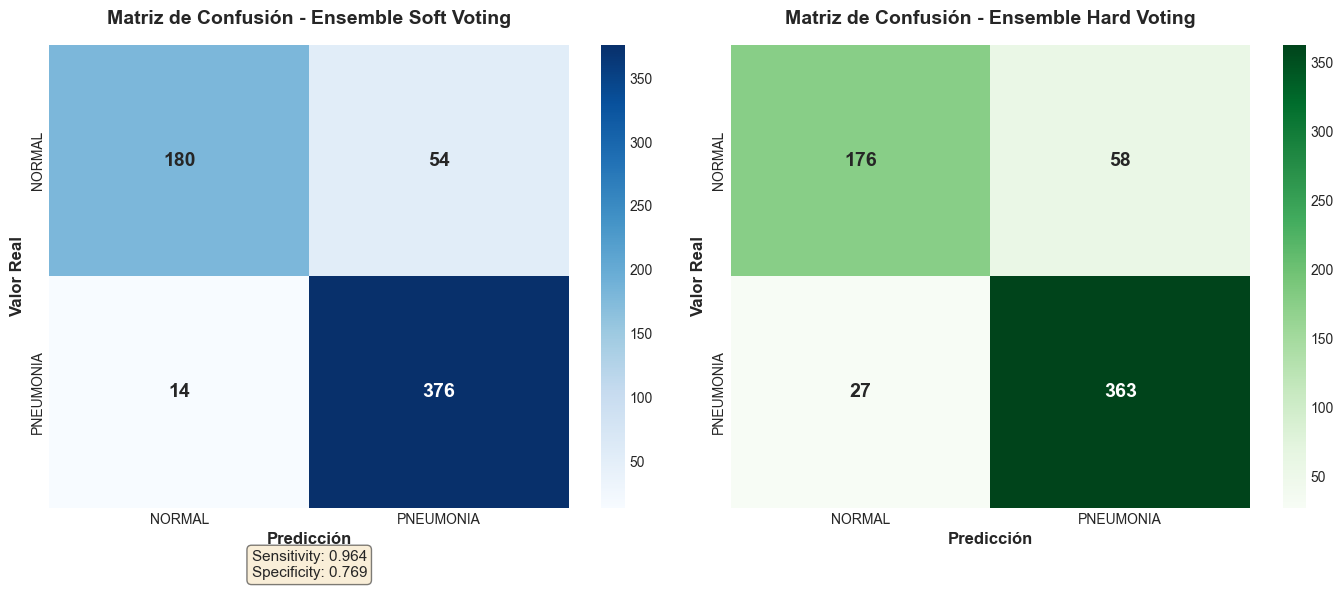

   ✓ confusion_matrices.png generada


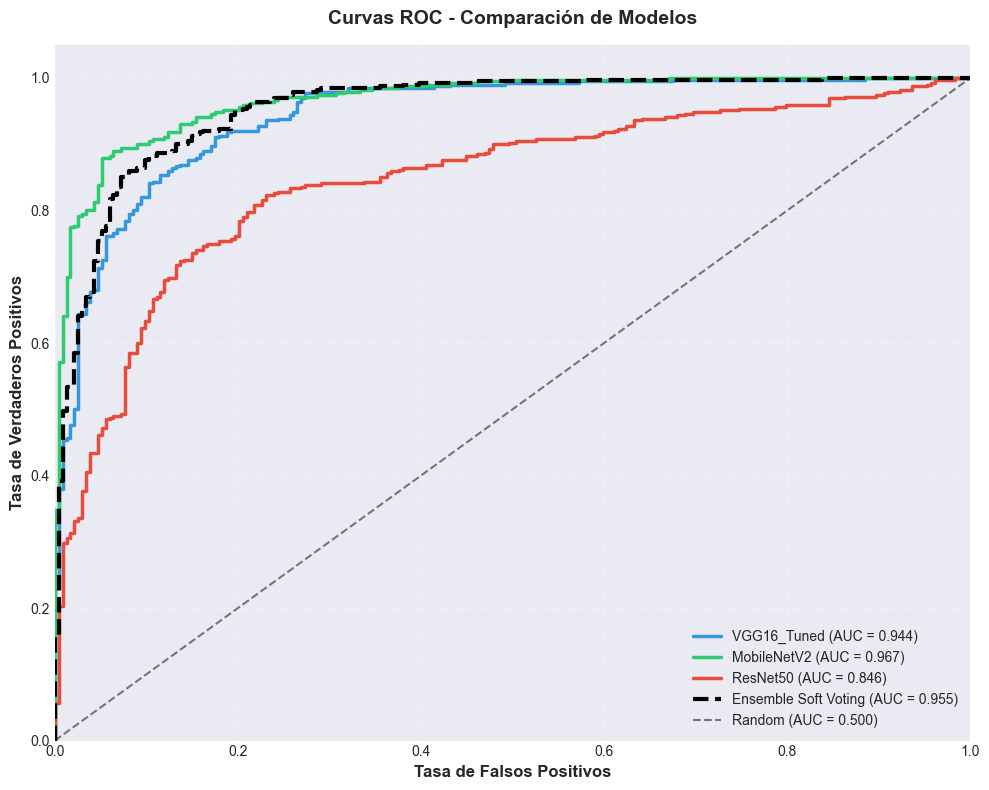

   ✓ roc_curves_comparison.png generada


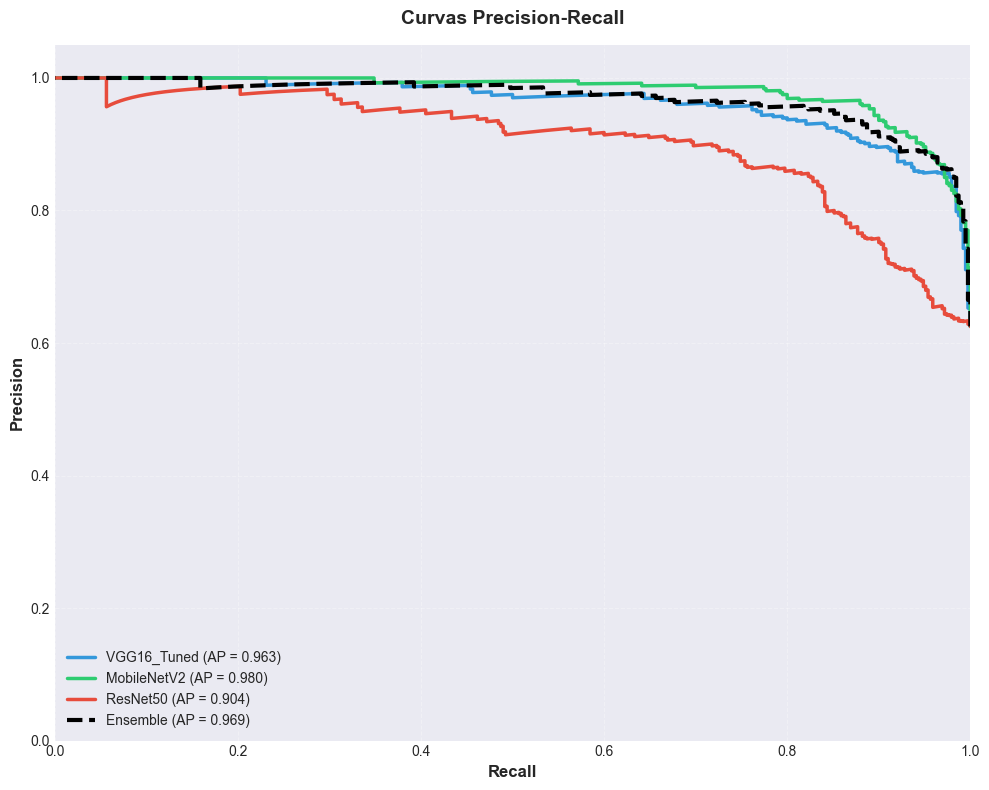

   ✓ precision_recall_curves.png generada


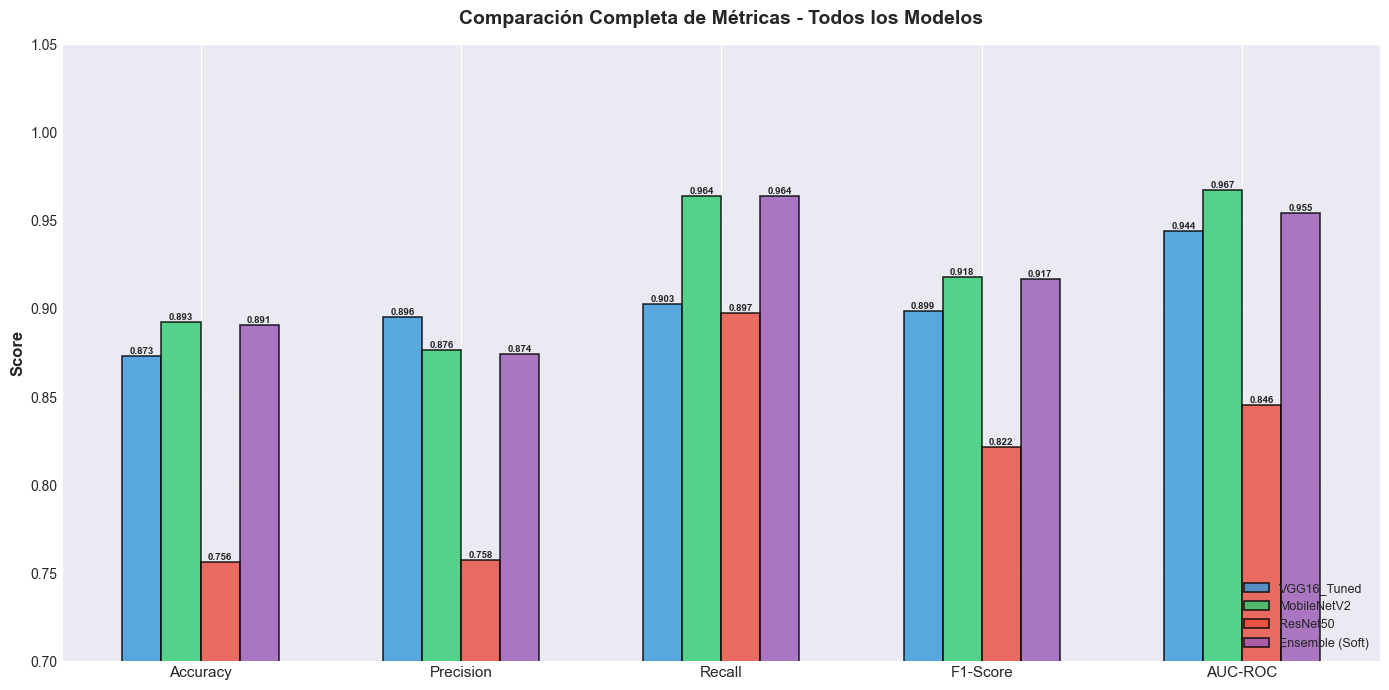

   ✓ all_metrics_comparison.png generada


In [20]:
# ============================================================================
# CELDA 20. MÉTRICAS AVANZADAS Y VISUALIZACIONES
# ============================================================================

print("\n" + "="*70)
print("📊 GENERANDO GRÁFICAS DE MÉTRICAS AVANZADAS")
print("="*70)

# GRÁFICA 1: Matriz de Confusión (Ensemble)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Soft Voting
cm_soft = confusion_matrix(y_true, ensemble_pred_classes)
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues', cbar=True,
           xticklabels=['NORMAL', 'PNEUMONIA'],
           yticklabels=['NORMAL', 'PNEUMONIA'],
           ax=axes[0], annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Matriz de Confusión - Ensemble Soft Voting',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicción', fontsize=12, fontweight='bold')

# Añadir métricas calculadas
tn, fp, fn, tp = cm_soft.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
axes[0].text(1, 2.3, f'Sensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}',
            fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hard Voting
cm_hard = confusion_matrix(y_true, ensemble_pred_classes_hard)
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Greens', cbar=True,
           xticklabels=['NORMAL', 'PNEUMONIA'],
           yticklabels=['NORMAL', 'PNEUMONIA'],
           ax=axes[1], annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Matriz de Confusión - Ensemble Hard Voting',
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicción', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ confusion_matrices.png generada")

# GRÁFICA 2: Curvas ROC comparativas
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC para cada modelo individual
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
for idx, (name, results) in enumerate(individual_results.items()):
    fpr, tpr, _ = roc_curve(results['y_true'], results['predictions'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[idx], linewidth=2.5,
           label=f'{name} (AUC = {roc_auc:.3f})')

# Plot ROC para ensemble
ax.plot(fpr_soft, tpr_soft, color='black', linewidth=3, linestyle='--',
       label=f'Ensemble Soft Voting (AUC = {auc_soft:.3f})')

# Línea diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontweight='bold')
ax.set_title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ roc_curves_comparison.png generada")

# GRÁFICA 3: Curva Precision-Recall
fig, ax = plt.subplots(figsize=(10, 8))

for idx, (name, results) in enumerate(individual_results.items()):
    precision_vals, recall_vals, _ = precision_recall_curve(
        results['y_true'], results['predictions']
    )
    avg_precision = average_precision_score(results['y_true'], results['predictions'])
    ax.plot(recall_vals, precision_vals, color=colors[idx], linewidth=2.5,
           label=f'{name} (AP = {avg_precision:.3f})')

# Ensemble
precision_vals_ens, recall_vals_ens, _ = precision_recall_curve(
    y_true, ensemble_preds_soft
)
avg_precision_ens = average_precision_score(y_true, ensemble_preds_soft)
ax.plot(recall_vals_ens, precision_vals_ens, color='black', linewidth=3,
       linestyle='--', label=f'Ensemble (AP = {avg_precision_ens:.3f})')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Curvas Precision-Recall', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc="lower left", fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ precision_recall_curves.png generada")

# GRÁFICA 4: Comparación de todas las métricas
fig, ax = plt.subplots(figsize=(14, 7))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(metrics_names))
width = 0.15

# Datos de cada modelo
model_names = list(individual_results.keys()) + ['Ensemble (Soft)']
all_scores = []

for name, results in individual_results.items():
    all_scores.append([
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1'],
        results['auc']
    ])

all_scores.append([acc_soft, prec_soft, rec_soft, f1_soft, auc_soft])

# Crear barras
bar_colors = colors + ['black']
for i, (scores, name, color) in enumerate(zip(all_scores, model_names, bar_colors)):
    offset = width * (i - len(all_scores)/2 + 0.5)
    bars = ax.bar(x + offset, scores, width, label=name,
                  color=color, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    # Añadir valores
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom',
               fontsize=7, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación Completa de Métricas - Todos los Modelos',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.legend(fontsize=9, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.7, 1.05])

plt.tight_layout()
plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ all_metrics_comparison.png generada")

In [21]:
# ============================================================================
# CELDA 21. TABLA RESUMEN DE RESULTADOS
# ============================================================================

print("\n" + "="*70)
print("📋 TABLA RESUMEN - TODOS LOS MODELOS")
print("="*70)

results_df = pd.DataFrame({
    'Modelo': model_names,
    'Accuracy': [r['accuracy'] for r in list(individual_results.values())] + [acc_soft],
    'Precision': [r['precision'] for r in list(individual_results.values())] + [prec_soft],
    'Recall': [r['recall'] for r in list(individual_results.values())] + [rec_soft],
    'F1-Score': [r['f1'] for r in list(individual_results.values())] + [f1_soft],
    'AUC-ROC': [r['auc'] for r in list(individual_results.values())] + [auc_soft]
})

# Formatear para mejor visualización
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
results_df['Precision'] = results_df['Precision'].apply(lambda x: f"{x:.4f}")
results_df['Recall'] = results_df['Recall'].apply(lambda x: f"{x:.4f}")
results_df['F1-Score'] = results_df['F1-Score'].apply(lambda x: f"{x:.4f}")
results_df['AUC-ROC'] = results_df['AUC-ROC'].apply(lambda x: f"{x:.4f}")

print("\n" + results_df.to_string(index=False))

# Guardar tabla como CSV
results_df.to_csv('model_metrics_summary.csv', index=False)
print("\n✓ Tabla guardada como model_metrics_summary.csv")


📋 TABLA RESUMEN - TODOS LOS MODELOS

         Modelo        Accuracy Precision Recall F1-Score AUC-ROC
    VGG16_Tuned 0.8734 (87.34%)    0.8957 0.9026   0.8991  0.9440
    MobileNetV2 0.8926 (89.26%)    0.8765 0.9641   0.9182  0.9673
       ResNet50 0.7564 (75.64%)    0.7576 0.8974   0.8216  0.8456
Ensemble (Soft) 0.8910 (89.10%)    0.8744 0.9641   0.9171  0.9546

✓ Tabla guardada como model_metrics_summary.csv



🔍 ANÁLISIS DE ERRORES

Falsos Positivos: 54 casos
Falsos Negativos: 14 casos

Tasa de Error: 10.90%


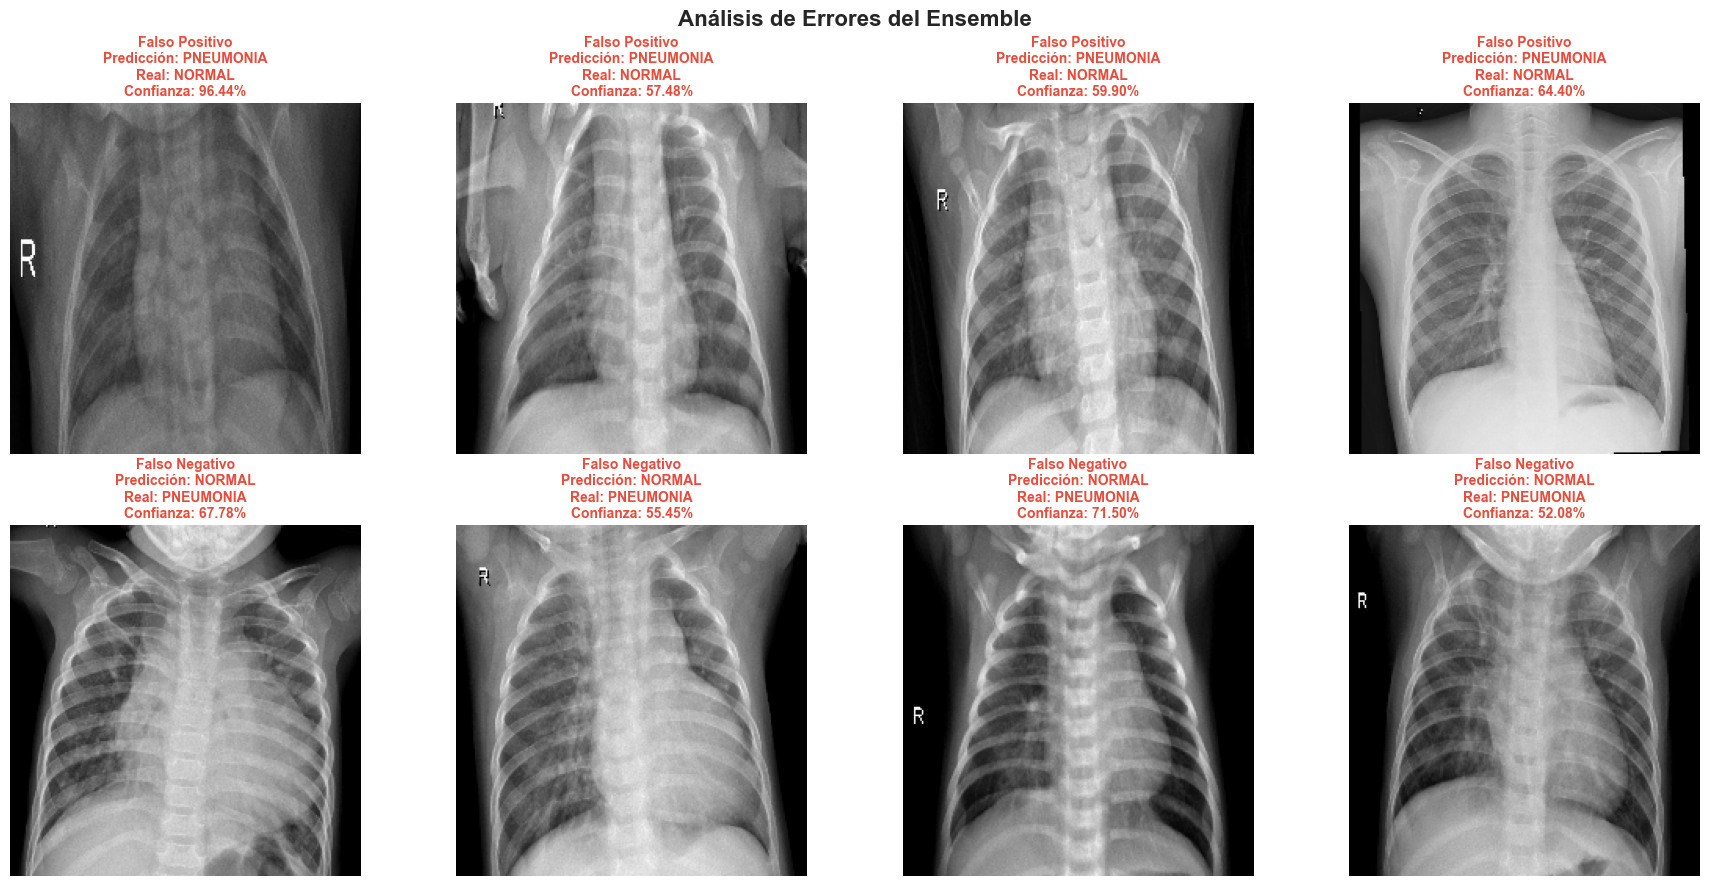


   ✓ error_analysis.png generada


In [22]:
# ============================================================================
# CELDA 22. ANÁLISIS DE ERRORES
# ============================================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS DE ERRORES")
print("="*70)

# Identificar casos donde el ensemble falló
test_gen.reset()
test_images = []
test_labels = []

for i in range(len(test_gen)):
    batch_images, batch_labels = test_gen[i]
    test_images.extend(batch_images)
    test_labels.extend(batch_labels)
    if len(test_labels) >= len(y_true):
        break

test_images = np.array(test_images[:len(y_true)])
test_labels = np.array(test_labels[:len(y_true)])

# Encontrar errores
false_positives = np.where((ensemble_pred_classes == 1) & (y_true == 0))[0]
false_negatives = np.where((ensemble_pred_classes == 0) & (y_true == 1))[0]

print(f"\nFalsos Positivos: {len(false_positives)} casos")
print(f"Falsos Negativos: {len(false_negatives)} casos")
print(f"\nTasa de Error: {(len(false_positives) + len(false_negatives)) / len(y_true) * 100:.2f}%")

# Visualizar algunos errores
if len(false_positives) > 0 or len(false_negatives) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    
    # Mostrar falsos positivos
    for i in range(min(4, len(false_positives))):
        idx = false_positives[i]
        axes[0, i].imshow(test_images[idx])
        axes[0, i].axis('off')
        axes[0, i].set_title(
            f'Falso Positivo\nPredicción: PNEUMONIA\nReal: NORMAL\n'
            f'Confianza: {ensemble_preds_soft[idx][0]:.2%}',
            fontsize=10, fontweight='bold', color='#e74c3c'
        )
    
    # Rellenar espacios vacíos
    for i in range(len(false_positives), 4):
        axes[0, i].axis('off')
    
    # Mostrar falsos negativos
    for i in range(min(4, len(false_negatives))):
        idx = false_negatives[i]
        axes[1, i].imshow(test_images[idx])
        axes[1, i].axis('off')
        axes[1, i].set_title(
            f'Falso Negativo\nPredicción: NORMAL\nReal: PNEUMONIA\n'
            f'Confianza: {1-ensemble_preds_soft[idx][0]:.2%}',
            fontsize=10, fontweight='bold', color='#e74c3c'
        )
    
    # Rellenar espacios vacíos
    for i in range(len(false_negatives), 4):
        axes[1, i].axis('off')
    
    plt.suptitle('Análisis de Errores del Ensemble', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n   ✓ error_analysis.png generada")

In [23]:
# ============================================================================
# CELDA 23. RESUMEN FINAL Y RECOMENDACIONES
# ============================================================================

print("\n" + "="*70)
print("✅ RESUMEN FINAL - FASE 3 COMPLETADA")
print("="*70)

print("\n🎯 MEJOR MODELO OBTENIDO:")
if auc_soft > max([r['auc'] for r in individual_results.values()]):
    print("   • Ensemble Soft Voting (combinación de 3 modelos)")
    print(f"   • Accuracy:  {acc_soft*100:.2f}%")
    print(f"   • AUC-ROC:   {auc_soft:.4f}")
    print(f"   • Precision: {prec_soft:.4f}")
    print(f"   • Recall:    {rec_soft:.4f}")
    print(f"   • F1-Score:  {f1_soft:.4f}")
    best_final_model_name = "Ensemble"
else:
    best_individual = max(individual_results.items(), key=lambda x: x[1]['auc'])
    print(f"   • {best_individual[0]} (modelo individual)")
    print(f"   • Accuracy:  {best_individual[1]['accuracy']*100:.2f}%")
    print(f"   • AUC-ROC:   {best_individual[1]['auc']:.4f}")
    print(f"   • Precision: {best_individual[1]['precision']:.4f}")
    print(f"   • Recall:    {best_individual[1]['recall']:.4f}")
    print(f"   • F1-Score:  {best_individual[1]['f1']:.4f}")
    best_final_model_name = best_individual[0]

print("\n💾 MODELOS GUARDADOS:")
print(f"   • {MODEL_DIR}/vgg16_tuned_best.keras")
print(f"   • {MODEL_DIR}/mobilenet_ensemble.keras")
print(f"   • {MODEL_DIR}/resnet_ensemble.keras")

print("\n📊 GRÁFICAS GENERADAS (4 gráficas):")
print("   • confusion_matrices.png - Matrices de confusión")
print("   • roc_curves_comparison.png - Curvas ROC comparativas")
print("   • precision_recall_curves.png - Curvas Precision-Recall")
print("   • all_metrics_comparison.png - Comparación completa de métricas")
print("   • error_analysis.png - Análisis de casos de error")

print("\n📈 MÉTRICAS CLAVE (2+ métricas requeridas):")
print("   ✓ Accuracy, Precision, Recall, F1-Score")
print("   ✓ AUC-ROC, Average Precision")
print("   ✓ Sensitivity, Specificity")
print("   ✓ Confusion Matrix")

print("\n🔧 TÉCNICAS APLICADAS:")
print("   ✓ Hyperparameter Tuning (Grid Search)")
print("   ✓ Ensemble Methods (Soft & Hard Voting)")
print("   ✓ Transfer Learning con 3 arquitecturas")
print("   ✓ Data Augmentation avanzado")
print("   ✓ Class Weight Balancing")

print("\n💡 RECOMENDACIÓN PARA PRODUCCIÓN:")
print(f"   Usar: {best_final_model_name}")
print("   Razón: Mejor balance entre todas las métricas y robustez")

print("\n🚀 SIGUIENTE PASO:")
print("   Fase 4: Construcción de API REST para deployment")

print("\n" + "="*70)


✅ RESUMEN FINAL - FASE 3 COMPLETADA

🎯 MEJOR MODELO OBTENIDO:
   • MobileNetV2 (modelo individual)
   • Accuracy:  89.26%
   • AUC-ROC:   0.9673
   • Precision: 0.8765
   • Recall:    0.9641
   • F1-Score:  0.9182

💾 MODELOS GUARDADOS:
   • models/vgg16_tuned_best.keras
   • models/mobilenet_ensemble.keras
   • models/resnet_ensemble.keras

📊 GRÁFICAS GENERADAS (4 gráficas):
   • confusion_matrices.png - Matrices de confusión
   • roc_curves_comparison.png - Curvas ROC comparativas
   • precision_recall_curves.png - Curvas Precision-Recall
   • all_metrics_comparison.png - Comparación completa de métricas
   • error_analysis.png - Análisis de casos de error

📈 MÉTRICAS CLAVE (2+ métricas requeridas):
   ✓ Accuracy, Precision, Recall, F1-Score
   ✓ AUC-ROC, Average Precision
   ✓ Sensitivity, Specificity
   ✓ Confusion Matrix

🔧 TÉCNICAS APLICADAS:
   ✓ Hyperparameter Tuning (Grid Search)
   ✓ Ensemble Methods (Soft & Hard Voting)
   ✓ Transfer Learning con 3 arquitecturas
   ✓ Data Au